In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path
import scipy.stats as stats
import warnings
import pickle
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
warnings.filterwarnings("ignore")

root_dir = Path.cwd().parent
print(root_dir)

# plot dpi
plt.rcParams['figure.dpi'] = 240

/DATA/Luis/thesis/scanline_classification


# All attributes together: model performance

n_estimators = 200

max_depth = 6

learning_rate = 0.3

In [2]:
testing_results_path = root_dir / 'data/final_results/0_all_attributes_performance_withtraining/all_results/testing_cls_results.csv'
validation_results_path = root_dir / 'data/final_results/0_all_attributes_performance_withtraining/all_results/validation_cls_results.csv'

testing_results = pd.read_csv(testing_results_path)
validation_results = pd.read_csv(validation_results_path)

# Rename the first columns
testing_results = testing_results.rename(columns={'Unnamed: 0': 'attribute'})
testing_results['mode'] = 'testing'
validation_results = validation_results.rename(columns={'Unnamed: 0': 'attribute'})
validation_results['mode'] = 'validation'

# Remove 'accuracy' and 'macro avg' rows
testing_results = testing_results[testing_results['attribute'] != 'accuracy']
testing_results = testing_results[testing_results['attribute'] != 'macro avg']
validation_results = validation_results[validation_results['attribute'] != 'accuracy']
validation_results = validation_results[validation_results['attribute'] != 'macro avg']

# Merge the two dataframes
all_results = pd.concat([testing_results, validation_results])

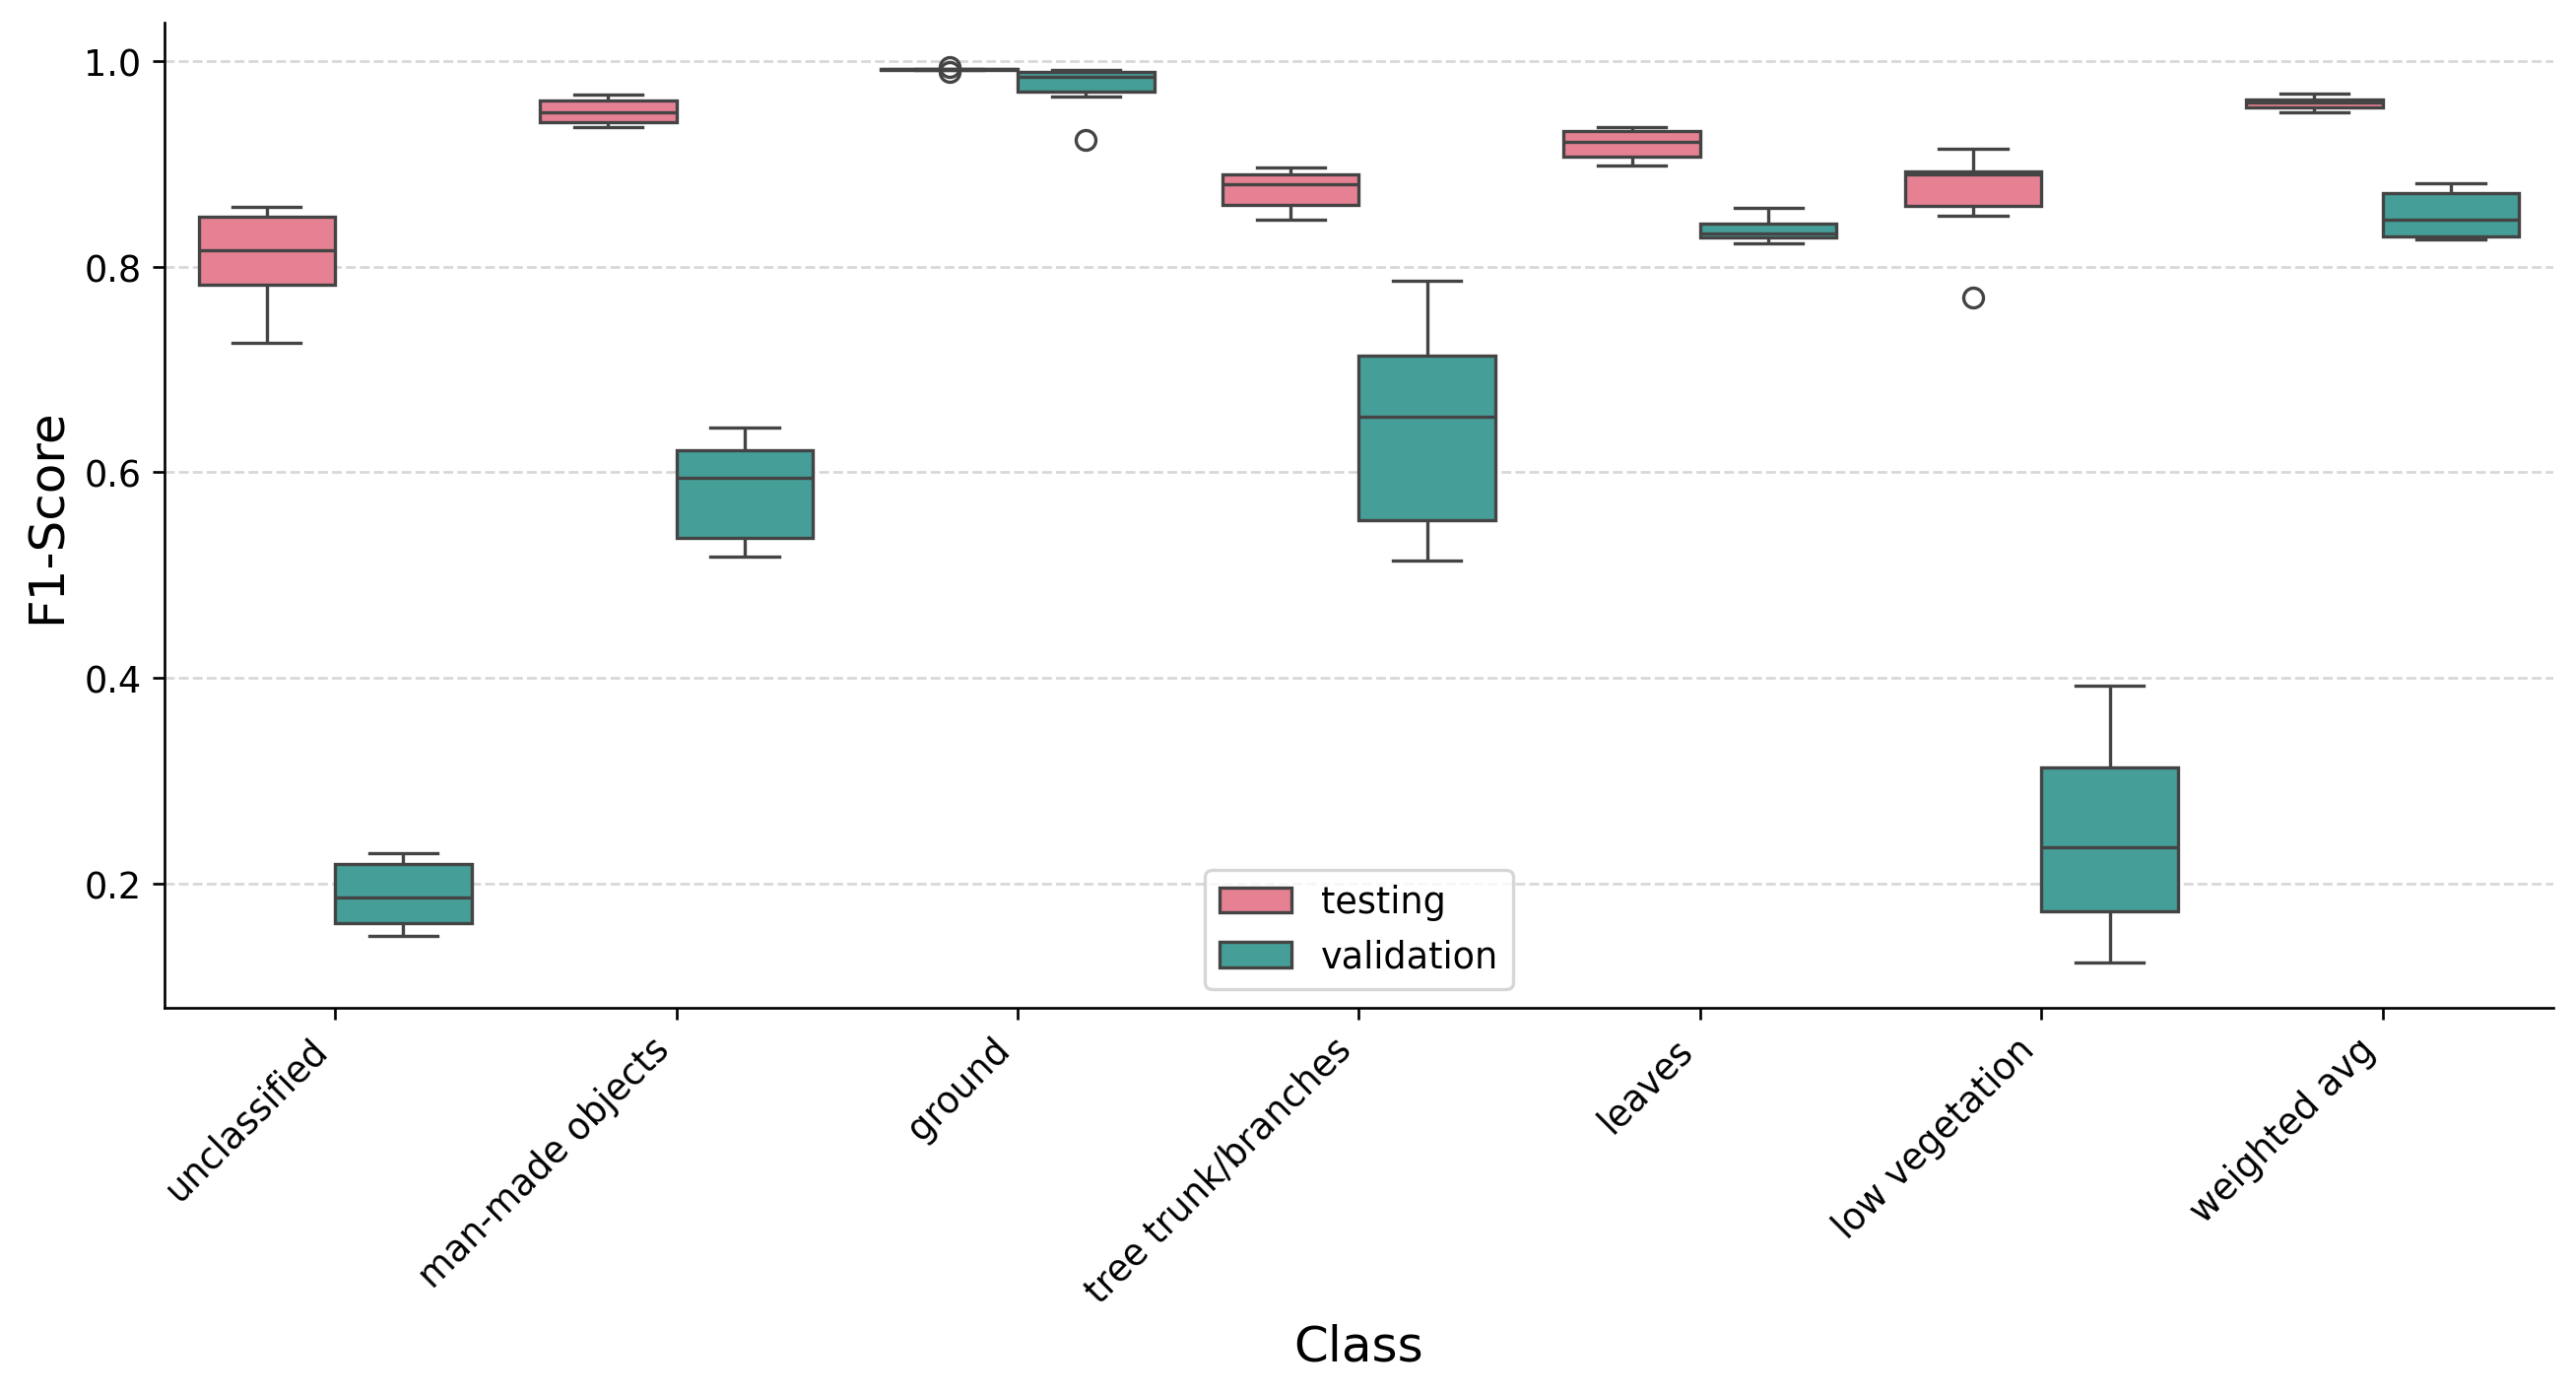

In [28]:
fig, ax1 = plt.subplots(figsize=(11, 6)) 

box_plot = sns.boxplot(x='attribute', y='f1-score', data=all_results, hue='mode', palette=sns.color_palette("husl", 2), ax=ax1)

# Highlight 'weighted avg' with light grey color
for i, artist in enumerate(box_plot.artists):
    print(i, artist.get_facecolor())
    print(artist)
    
    # This artist contains rectangle for boxplot
    if box_plot.get_xticklabels()[i].get_text() == 'weighted avg':
        print('weighted avg')
        artist.set_facecolor('lightgrey')

ax1.set_xlabel('Class', fontdict={'size': 15})
ax1.set_ylabel('F1-Score', fontdict={'size': 15})

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Set the size of the tick labels
ax1.tick_params(axis='y', labelsize=11)
ax1.tick_params(axis='x', labelsize=11)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')

# Add grid
ax1.grid(True, axis='y', linestyle='--', alpha=0.5)

# Ajust legend
ax1.legend(loc='lower center', fontsize=11, title='')

plt.tight_layout()
plt.show()

In [19]:
all_results.groupby(['attribute', 'mode'])['f1-score'].describe()

count      mean       std       min       25%  \
attribute           mode                                                        
ground              testing       6.0  0.992257  0.001321  0.990006  0.991904   
                    validation    6.0  0.973502  0.026134  0.923734  0.969970   
leaves              testing       6.0  0.919198  0.015838  0.898811  0.906750   
                    validation    6.0  0.836229  0.012776  0.822765  0.828184   
low vegetation      testing       6.0  0.868001  0.052439  0.770191  0.859161   
                    validation    6.0  0.245863  0.102487  0.122599  0.172431   
man-made objects    testing       6.0  0.950974  0.013376  0.935791  0.940435   
                    validation    6.0  0.582972  0.053369  0.517630  0.536383   
tree trunk/branches testing       6.0  0.874982  0.020459  0.846074  0.860296   
                    validation    6.0  0.643530  0.108724  0.513695  0.552910   
unclassified        testing       6.0  0.807881  0.050879  0.726089  0.782788   
                    validation    6.0  0.188714  0.034330  0.149042  0.160778   
weighted avg        testing       6.0  0.959138  0.006535  0.949810  0.955426   
                    validation    6.0  0.850522  0.024362  0.826714  0.829623   

                                     50%       75%       max  
attribute           mode                                      
ground              testing     0.992581  0.992689  0.993968  
                    validation  0.985152  0.989223  0.991487  
leaves              testing     0.921903  0.931919  0.935612  
                    validation  0.832720  0.841779  0.857701  
low vegetation      testing     0.890248  0.892488  0.915285  
                    validation  0.235367  0.312705  0.391910  
man-made objects    testing     0.949876  0.961654  0.967433  
                    validation  0.594265  0.621607  0.643865  
tree trunk/branches testing     0.880363  0.890063  0.896187  
                    validation  0.654121  0.713821  0.786351  
unclassified        testing     0.816273  0.848378  0.857947  
                    validation  0.186290  0.218750  0.228817  
weighted avg        testing     0.959454  0.962721  0.968217  
                    validation  0.845312  0.871738  0.880853

## Confusion matrices

### Training

In [46]:
cnf_mat_testing_results_path = root_dir / 'data/final_results/0_all_attributes_performance_withtraining/confusion_matrices_testing'

In [61]:
# Initialize a matrix to hold the sum
sum_matrix = None

# Create a Path object
path = Path(cnf_mat_testing_results_path)

# Loop through all .csv files in the directory
for filename in path.glob('*.csv'):
    # Load the matrix from the file
    matrix = np.loadtxt(filename, delimiter=',')

    # If this is the first matrix, initialize sum_matrix
    if sum_matrix is None:
        sum_matrix = matrix
    else:
        # Add the matrix to the sum
        sum_matrix += matrix

# Normalize the sum_matrix over the rows
row_sums = sum_matrix.sum(axis=1, keepdims=True)
normalized_matrix = sum_matrix / row_sums

names = ['unclassified', 'man-made objects', 'ground', 'tree trunk/branches', 'leaves', 'low vegetation']
cnf_mat_testing_df = pd.DataFrame(np.round(normalized_matrix,4), index=names, columns=names)

In [62]:
cnf_mat_testing_df

,unclassified,man-made objects,ground,tree trunk/branches,leaves,low vegetation
unclassified,0.8339,0.1161,0.0239,0.0069,0.0099,0.0094
man-made objects,0.0113,0.9447,0.0280,0.0107,0.0022,0.0030
ground,0.0001,0.0010,0.9979,0.0001,0.0003,0.0006
tree trunk/branches,0.0022,0.0193,0.0137,0.8850,0.0759,0.0039
leaves,0.0046,0.0016,0.0121,0.0815,0.8978,0.0025
low vegetation,0.0119,0.0256,0.0678,0.0052,0.0009,0.8886


### Validation

In [63]:
cnf_mat_validation_results_path = root_dir / 'data/final_results/0_all_attributes_performance_withtraining/confusion_matrices_validation'

In [64]:
# Initialize a matrix to hold the sum
sum_matrix = None

# Create a Path object
path = Path(cnf_mat_validation_results_path)

# Loop through all .csv files in the directory
for filename in path.glob('*.csv'):
    # Load the matrix from the file
    matrix = np.loadtxt(filename, delimiter=',')

    # If this is the first matrix, initialize sum_matrix
    if sum_matrix is None:
        sum_matrix = matrix
    else:
        # Add the matrix to the sum
        sum_matrix += matrix

# Normalize the sum_matrix over the rows
row_sums = sum_matrix.sum(axis=1, keepdims=True)
normalized_matrix = sum_matrix / row_sums

names = ['unclassified', 'man-made objects', 'ground', 'tree trunk/branches', 'leaves', 'low vegetation']
cnf_mat_validation_df = pd.DataFrame(np.round(normalized_matrix,4), index=names, columns=names)

In [65]:
cnf_mat_validation_df

,unclassified,man-made objects,ground,tree trunk/branches,leaves,low vegetation
unclassified,0.6547,0.1603,0.0415,0.0389,0.0719,0.0327
man-made objects,0.0847,0.4965,0.0097,0.3955,0.0129,0.0008
ground,0.0052,0.0144,0.9671,0.0009,0.0007,0.0117
tree trunk/branches,0.0270,0.1338,0.0207,0.7185,0.0866,0.0134
leaves,0.0340,0.0077,0.0107,0.1459,0.7914,0.0103
low vegetation,0.3830,0.1170,0.1471,0.0152,0.0171,0.3206


# Feature importance

## Overall result

In [66]:
dir = Path("/DATA/Luis/thesis/scanline_classification/data/data_for_training_final_SM2CT20NM3_v02/classification_training_sample10000/all_results/feature_importance_results_full_res.csv")
df = pd.read_csv(dir)

df['feature_importance'] = -999.0
classes = ['unclassified', 'man-made objects', 'ground', 'tree trunk/branches', 'leaves', 'low vegetation']
stats = df['statistics'].unique()
filenames = df['filename'].unique()

In [68]:
metric = 'f1-score'

for filename in filenames:
    for stat in stats:
        for cl in classes:
            df_subset = df[(df['filename'] == filename) & (df['statistics'] == stat) & (df['attribute'] == cl)]
            baseline_f1 = df_subset[df_subset['baseline_model'] == 1][metric].values[0]
            feature_importance = baseline_f1 - df_subset[metric]
            df.loc[df_subset.index, 'feature_importance'] = feature_importance
            
df_analysis = df[df['feature_importance'] != -999.0]

In [69]:
order = df_analysis.groupby('drop_col')['feature_importance'].mean().sort_values(ascending=False).index
order_dict = {value: i for i, value in enumerate(order)}
df_analysis['order'] = df_analysis['drop_col'].map(order_dict)
df_analysis = df_analysis.sort_values('order')
df_analysis = df_analysis.drop(columns='order')
df_analysis = df_analysis[df_analysis['drop_col'] != 'none']

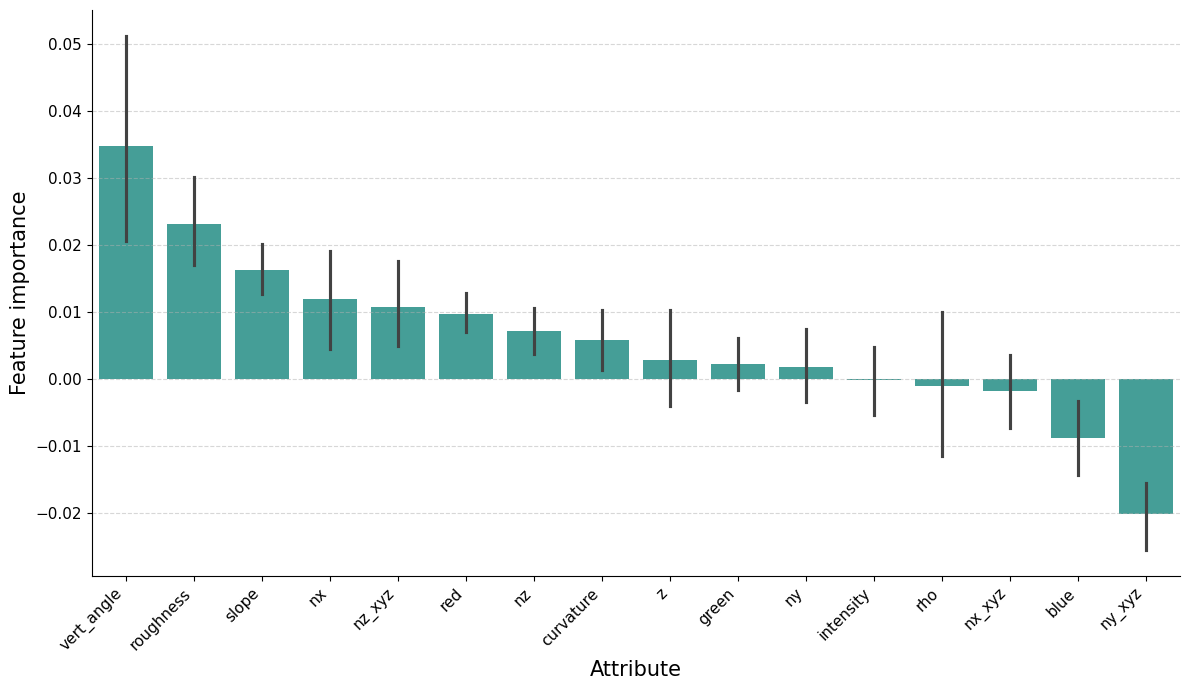

In [70]:
fig, ax1 = plt.subplots(figsize=(12, 7)) 

sns.barplot(x='drop_col', y='feature_importance', data=df_analysis, color=sns.color_palette("husl", 4)[2], ax=ax1)
ax1.set_xlabel('Attribute', fontdict={'size': 15})
ax1.set_ylabel('Feature importance', fontdict={'size': 15})

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Set the size of the tick labels
ax1.tick_params(axis='y', labelsize=11)
ax1.tick_params(axis='x', labelsize=11)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')

# Add grid
ax1.grid(True, axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

## Each class

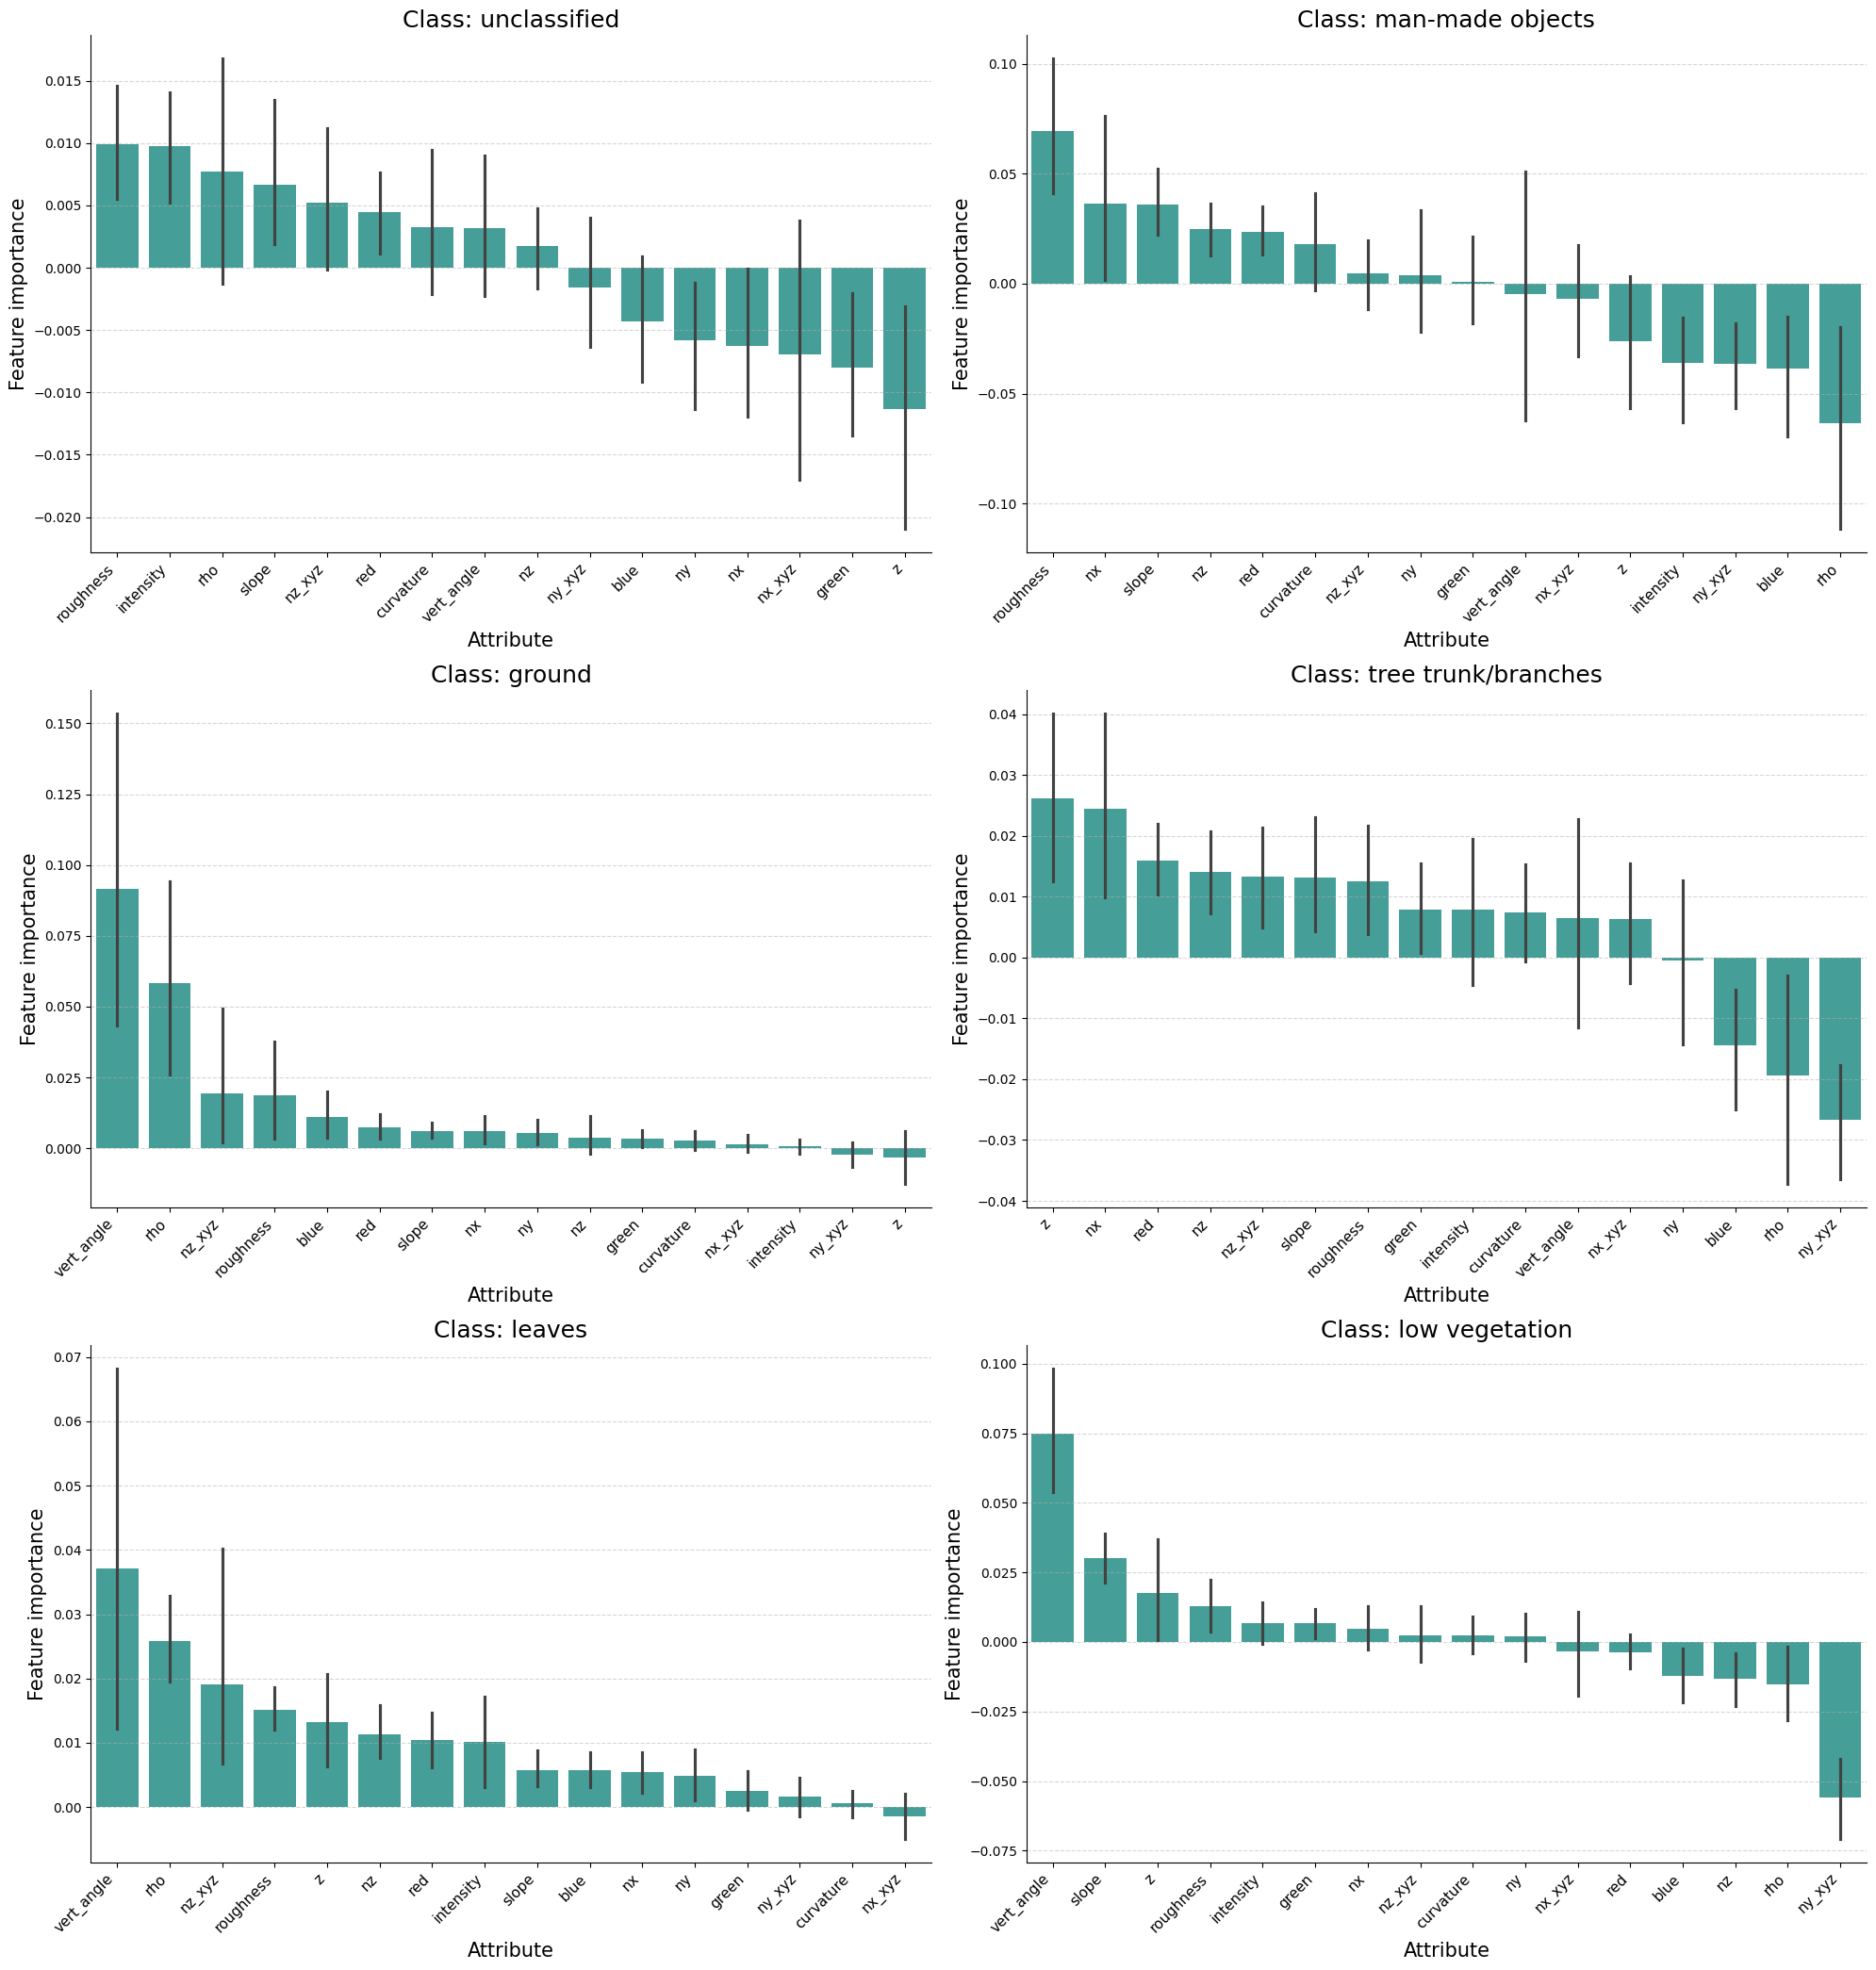

In [71]:
# Get unique statistics
cl = df_analysis['attribute'].unique()

# Calculate number of rows and columns for subplots
n = len(cl)
ncols = 2
nrows = n // ncols if n % ncols == 0 else n // ncols + 1

fig, axs = plt.subplots(nrows, ncols, figsize=(10*ncols, 7*nrows))

# Flatten the axes array to easily iterate over it
axs = axs.flatten()

for i, class_name in enumerate(cl):
    # Subset the dataframe for the current statistic
    df_subset = df_analysis[df_analysis['attribute'] == class_name]
    
    order = df_subset.groupby('drop_col')['feature_importance'].mean().sort_values(ascending=False).index
    order_dict = {value: i for i, value in enumerate(order)}
    df_subset['order'] = df_subset['drop_col'].map(order_dict)
    df_subset = df_subset.sort_values('order')
    df_subset = df_subset.drop(columns='order')
    df_subset = df_subset[df_subset['drop_col'] != 'none']
    
    # Create a barplot for the current statistic
    sns.barplot(x='drop_col', y='feature_importance', data=df_subset, color=sns.color_palette("husl", 4)[2], ax=axs[i])
    
    # Set x and y labels
    axs[i].set_xlabel('Attribute', fontdict={'size': 15})
    axs[i].set_ylabel('Feature importance', fontdict={'size': 15})
    
    # Set title for the subplot
    axs[i].set_title(f'Class: {class_name}', fontdict={'size': 18})

    # Remove top and right spines
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)

    # Set the size of the tick labels
    axs[i].tick_params(axis='x', labelsize=11)
    axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=45, ha='right')

    # Add grid
    axs[i].grid(True, axis='y', linestyle='--', alpha=0.5)

# Remove extra subplots
if n < nrows * ncols:
    for ax in axs[n:]:
        fig.delaxes(ax)


plt.tight_layout()
plt.show()

## Feature importance of statistics

In [72]:
dir = Path("/DATA/Luis/thesis/scanline_classification/data/data_for_training_final_SM2CT20NM3_v02/feature_importance_stats/all_results/cls_results_fr.csv")
df = pd.read_csv(dir)

df['feature_importance'] = -999.0
classes = ['unclassified', 'man-made objects', 'ground', 'tree trunk/branches', 'leaves', 'low vegetation']
stats = df['drop_statistics'].unique()
columns = df['column'].unique()
filenames = df['filename'].unique()

# Rename the first column
df = df.rename(columns={'Unnamed: 0': 'attribute'})


In [74]:
metric = 'f1-score'

for filename in filenames:
    for col in columns:
        for cl in classes:
            df_subset = df[(df['filename'] == filename) & (df['column'] == col) & (df['attribute'] == cl)]
            baseline_f1 = df_subset[df_subset['baseline_model'] == 1][metric].values[0]
            feature_importance = baseline_f1 - df_subset[metric]
            df.loc[df_subset.index, 'feature_importance'] = feature_importance

In [75]:
df_analysis = df[df['feature_importance'] != -999.0]

order = df_analysis.groupby('drop_statistics')['feature_importance'].mean().sort_values(ascending=False).index
order_dict = {value: i for i, value in enumerate(order)}
df_analysis['order'] = df_analysis['drop_statistics'].map(order_dict)
df_analysis = df_analysis.sort_values('order')
df_analysis = df_analysis.drop(columns='order')
df_analysis = df_analysis[df_analysis['drop_statistics'] != 'none']

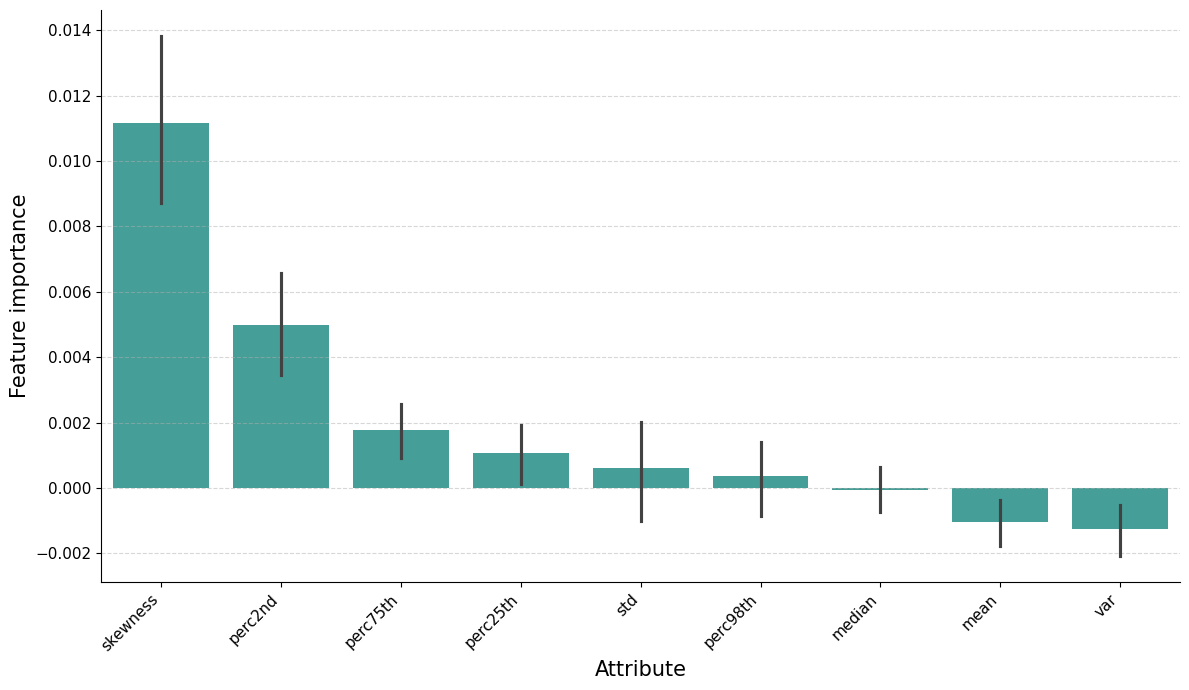

In [76]:
fig, ax1 = plt.subplots(figsize=(12, 7)) 

sns.barplot(x='drop_statistics', y='feature_importance', data=df_analysis, color=sns.color_palette("husl", 4)[2], ax=ax1)
ax1.set_xlabel('Attribute', fontdict={'size': 15})
ax1.set_ylabel('Feature importance', fontdict={'size': 15})

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Set the size of the tick labels
ax1.tick_params(axis='y', labelsize=11)
ax1.tick_params(axis='x', labelsize=11)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')

# Add grid
ax1.grid(True, axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# Hyperparameter testing

In [127]:
testing_dir = Path("/DATA/Luis/thesis/scanline_classification/data/final_results/2_hyperparameter_testing/fine/all_results/testing_cls_results.csv")
validation_dir = Path("/DATA/Luis/thesis/scanline_classification/data/final_results/2_hyperparameter_testing/fine/all_results/validation_cls_results.csv")
testing_df = pd.read_csv(testing_dir)
validation_df = pd.read_csv(validation_dir)

# Rename the first column
testing_df = testing_df.rename(columns={testing_df.columns[0]: "attribute"})
validation_df = validation_df.rename(columns={validation_df.columns[0]: "attribute"})

testing_avg = testing_df[testing_df["attribute"] == "weighted avg"]
validation_avg = validation_df[validation_df["attribute"] == "weighted avg"]

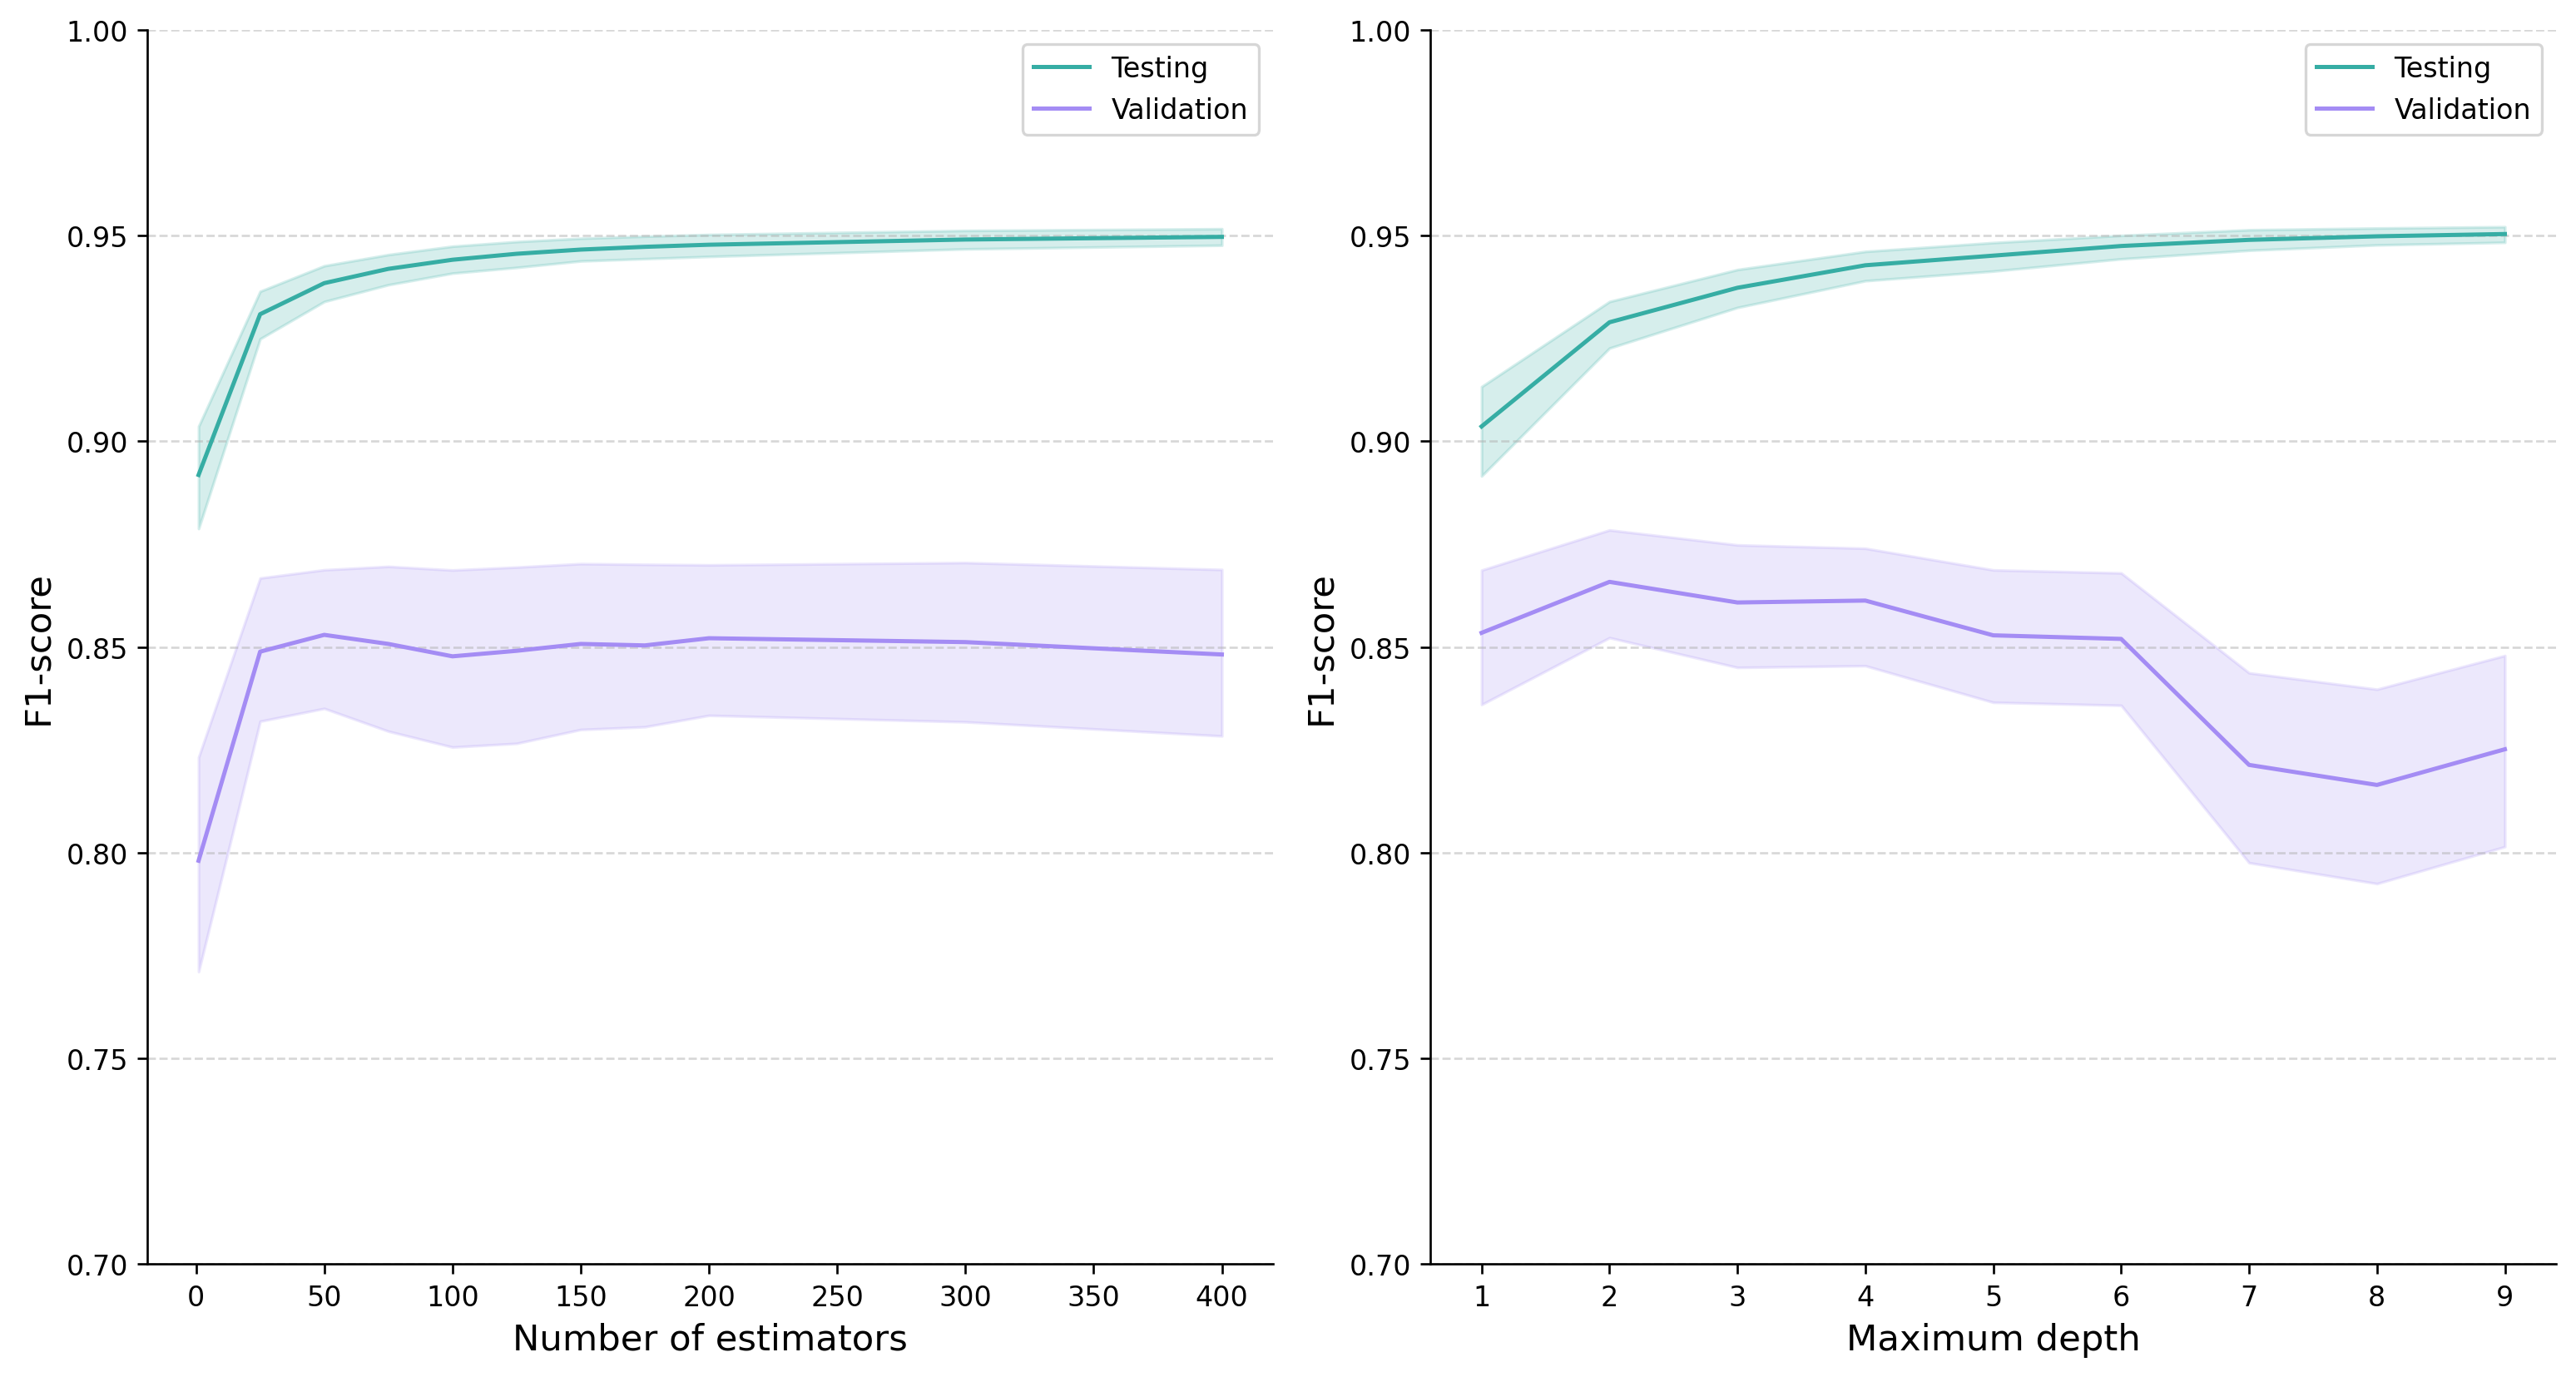

In [129]:
fig, axes = plt.subplots(1,2, figsize=(13, 7)) 

sns.lineplot(x='n_estimators', y='f1-score', data=testing_avg, color=sns.color_palette("husl", 4)[2], ax=axes[0], label="Testing")
sns.lineplot(x='n_estimators', y='f1-score', data=validation_avg, color=sns.color_palette("husl", 4)[3], ax=axes[0], label="Validation")
axes[0].set_xlabel('Number of estimators', fontdict={'size': 13})
axes[0].set_ylabel('F1-score', fontdict={'size': 13})
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].tick_params(axis='y', labelsize=10)
axes[0].tick_params(axis='x', labelsize=10)
axes[0].grid(True, axis='y', linestyle='--', alpha=0.5)
axes[0].set_ylim(0.7, 1)

sns.lineplot(x='max_depth', y='f1-score', data=testing_avg, color=sns.color_palette("husl", 4)[2], ax=axes[1], label="Testing")
sns.lineplot(x='max_depth', y='f1-score', data=validation_avg, color=sns.color_palette("husl", 4)[3], ax=axes[1], label="Validation")
axes[1].set_xlabel('Maximum depth', fontdict={'size': 13})
axes[1].set_ylabel('F1-score', fontdict={'size': 13})
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].tick_params(axis='y', labelsize=10)
axes[1].tick_params(axis='x', labelsize=10)
axes[1].grid(True, axis='y', linestyle='--', alpha=0.5)
axes[1].set_ylim(0.7, 1)

plt.tight_layout()
plt.show()

## Per class

In [31]:
testing_df_unclassified = testing_df[testing_df["attribute"] == "unclassified"]
validation_df_unclassified = validation_df[validation_df["attribute"] == "unclassified"]

testing_df_mmo = testing_df[testing_df["attribute"] == "man-made objects"]
validation_df_mmo = validation_df[validation_df["attribute"] == "man-made objects"]

testing_df_ground = testing_df[testing_df["attribute"] == "ground"]
validation_df_ground = validation_df[validation_df["attribute"] == "ground"]

testing_df_tree = testing_df[testing_df["attribute"] == "tree trunk/branches"]
validation_df_tree = validation_df[validation_df["attribute"] == "tree trunk/branches"]

testing_df_leaves = testing_df[testing_df["attribute"] == "leaves"]
validation_df_leaves = validation_df[validation_df["attribute"] == "leaves"]

testing_df_lowveg = testing_df[testing_df["attribute"] == "low vegetation"]
validation_df_lowveg = validation_df[validation_df["attribute"] == "low vegetation"]

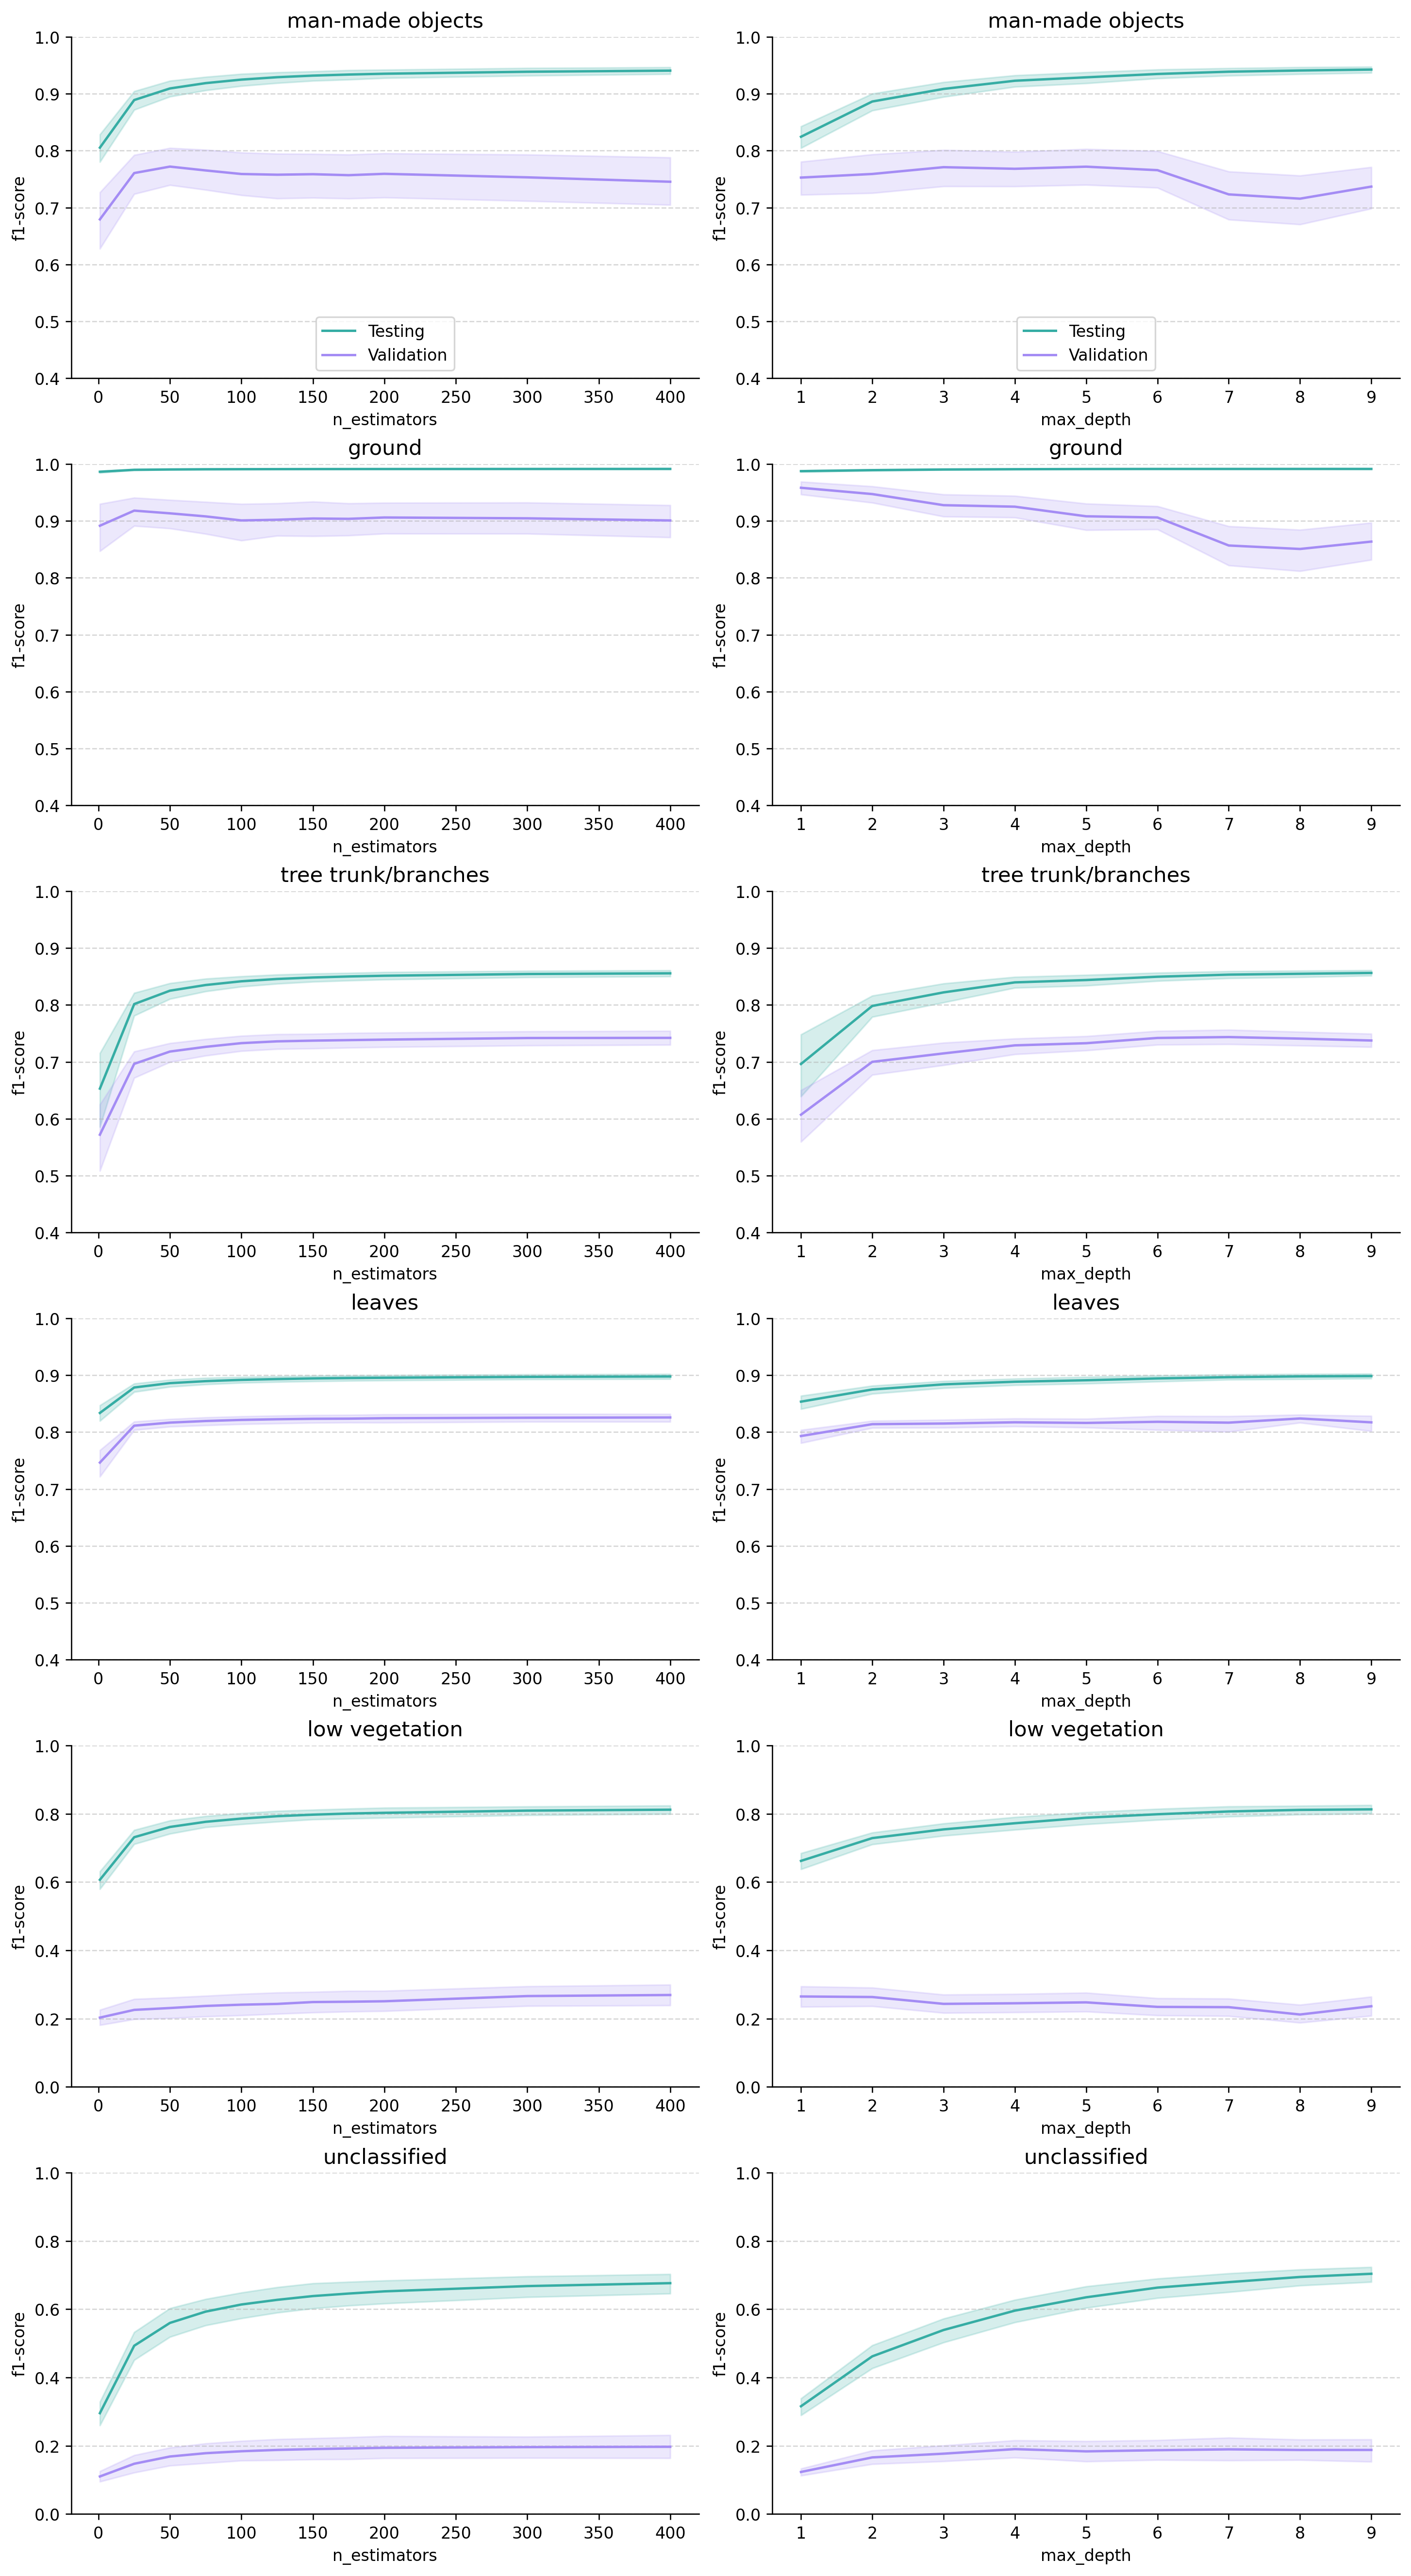

In [35]:
def plot_data(testing_df, validation_df, ax, x_var, y_var, color1, color2, title, legend=True, y_lim=(0.4, 1)):
    if legend:
        sns.lineplot(x=x_var, y=y_var, data=testing_df, color=color1, ax=ax, label="Testing")
        sns.lineplot(x=x_var, y=y_var, data=validation_df, color=color2, ax=ax, label="Validation")
        ax.legend(loc='lower center')
    else:
        sns.lineplot(x=x_var, y=y_var, data=testing_df, color=color1, ax=ax)
        sns.lineplot(x=x_var, y=y_var, data=validation_df, color=color2, ax=ax)
    
    # ax.set_xlabel(' ', fontdict={'size': 13})
    # ax.set_ylabel(' ', fontdict={'size': 13})
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='y', labelsize=10)
    ax.tick_params(axis='x', labelsize=10)
    ax.set_ylim(y_lim)
    ax.grid(True, axis='y', linestyle='--', alpha=0.5)
    ax.set_title(title, fontdict={'size': 13})
    

fig, axes = plt.subplots(6,2, figsize=(12, 22), constrained_layout=True) 

color1 = sns.color_palette("husl", 4)[2]
color2 = sns.color_palette("husl", 4)[3]

plot_data(testing_df_mmo, validation_df_mmo, axes[0,0], 'n_estimators', 'f1-score', color1, color2, testing_df_mmo['attribute'].values[0])
plot_data(testing_df_mmo, validation_df_mmo, axes[0,1], 'max_depth', 'f1-score', color1, color2, testing_df_mmo['attribute'].values[0])
plot_data(testing_df_ground, validation_df_ground, axes[1,0], 'n_estimators', 'f1-score', color1, color2, testing_df_ground['attribute'].values[0], False)
plot_data(testing_df_ground, validation_df_ground, axes[1,1], 'max_depth', 'f1-score', color1, color2, testing_df_ground['attribute'].values[0], False)
plot_data(testing_df_tree, validation_df_tree, axes[2,0], 'n_estimators', 'f1-score', color1, color2, testing_df_tree['attribute'].values[0], False)
plot_data(testing_df_tree, validation_df_tree, axes[2,1], 'max_depth', 'f1-score', color1, color2, testing_df_tree['attribute'].values[0], False)
plot_data(testing_df_leaves, validation_df_leaves, axes[3,0], 'n_estimators', 'f1-score', color1, color2, testing_df_leaves['attribute'].values[0], False)
plot_data(testing_df_leaves, validation_df_leaves, axes[3,1], 'max_depth', 'f1-score', color1, color2, testing_df_leaves['attribute'].values[0], False)
plot_data(testing_df_lowveg, validation_df_lowveg, axes[4,0], 'n_estimators', 'f1-score', color1, color2, testing_df_lowveg['attribute'].values[0], False, (0, 1))
plot_data(testing_df_lowveg, validation_df_lowveg, axes[4,1], 'max_depth', 'f1-score', color1, color2, testing_df_lowveg['attribute'].values[0], False, (0, 1))
plot_data(testing_df_unclassified, validation_df_unclassified, axes[5,0], 'n_estimators', 'f1-score', color1, color2, testing_df_unclassified['attribute'].values[0], False, (0, 1))
plot_data(testing_df_unclassified, validation_df_unclassified, axes[5,1], 'max_depth', 'f1-score', color1, color2, testing_df_unclassified['attribute'].values[0], False, (0, 1))

# Improved classification:

Attributes used:
- Vertical angle, Roughness, Slope, Nx, Ny, Nz, Curvature, Z, Green, Ny

Statistics used: 
- Skewness, 2nd percentile, 75th percentile, 25th percentile, StdDev, 98th percentile

XGBoost parameters used: 
- n_estimators: 100
- max_depth: 3
- learning_rate: 0.3

In [36]:
testing_results_path = root_dir / 'data/final_results/1_best_overall_performance/all_results/testing_cls_results.csv'
validation_results_path = root_dir / 'data/final_results/1_best_overall_performance/all_results/validation_cls_results.csv'

testing_results = pd.read_csv(testing_results_path)
validation_results = pd.read_csv(validation_results_path)

# Rename the first columns
testing_results = testing_results.rename(columns={'Unnamed: 0': 'attribute'})
testing_results['mode'] = 'testing'
validation_results = validation_results.rename(columns={'Unnamed: 0': 'attribute'})
validation_results['mode'] = 'validation'

# Remove 'accuracy' and 'macro avg' rows
testing_results = testing_results[testing_results['attribute'] != 'accuracy']
testing_results = testing_results[testing_results['attribute'] != 'macro avg']
validation_results = validation_results[validation_results['attribute'] != 'accuracy']
validation_results = validation_results[validation_results['attribute'] != 'macro avg']

# Merge the two dataframes
all_results = pd.concat([testing_results, validation_results])

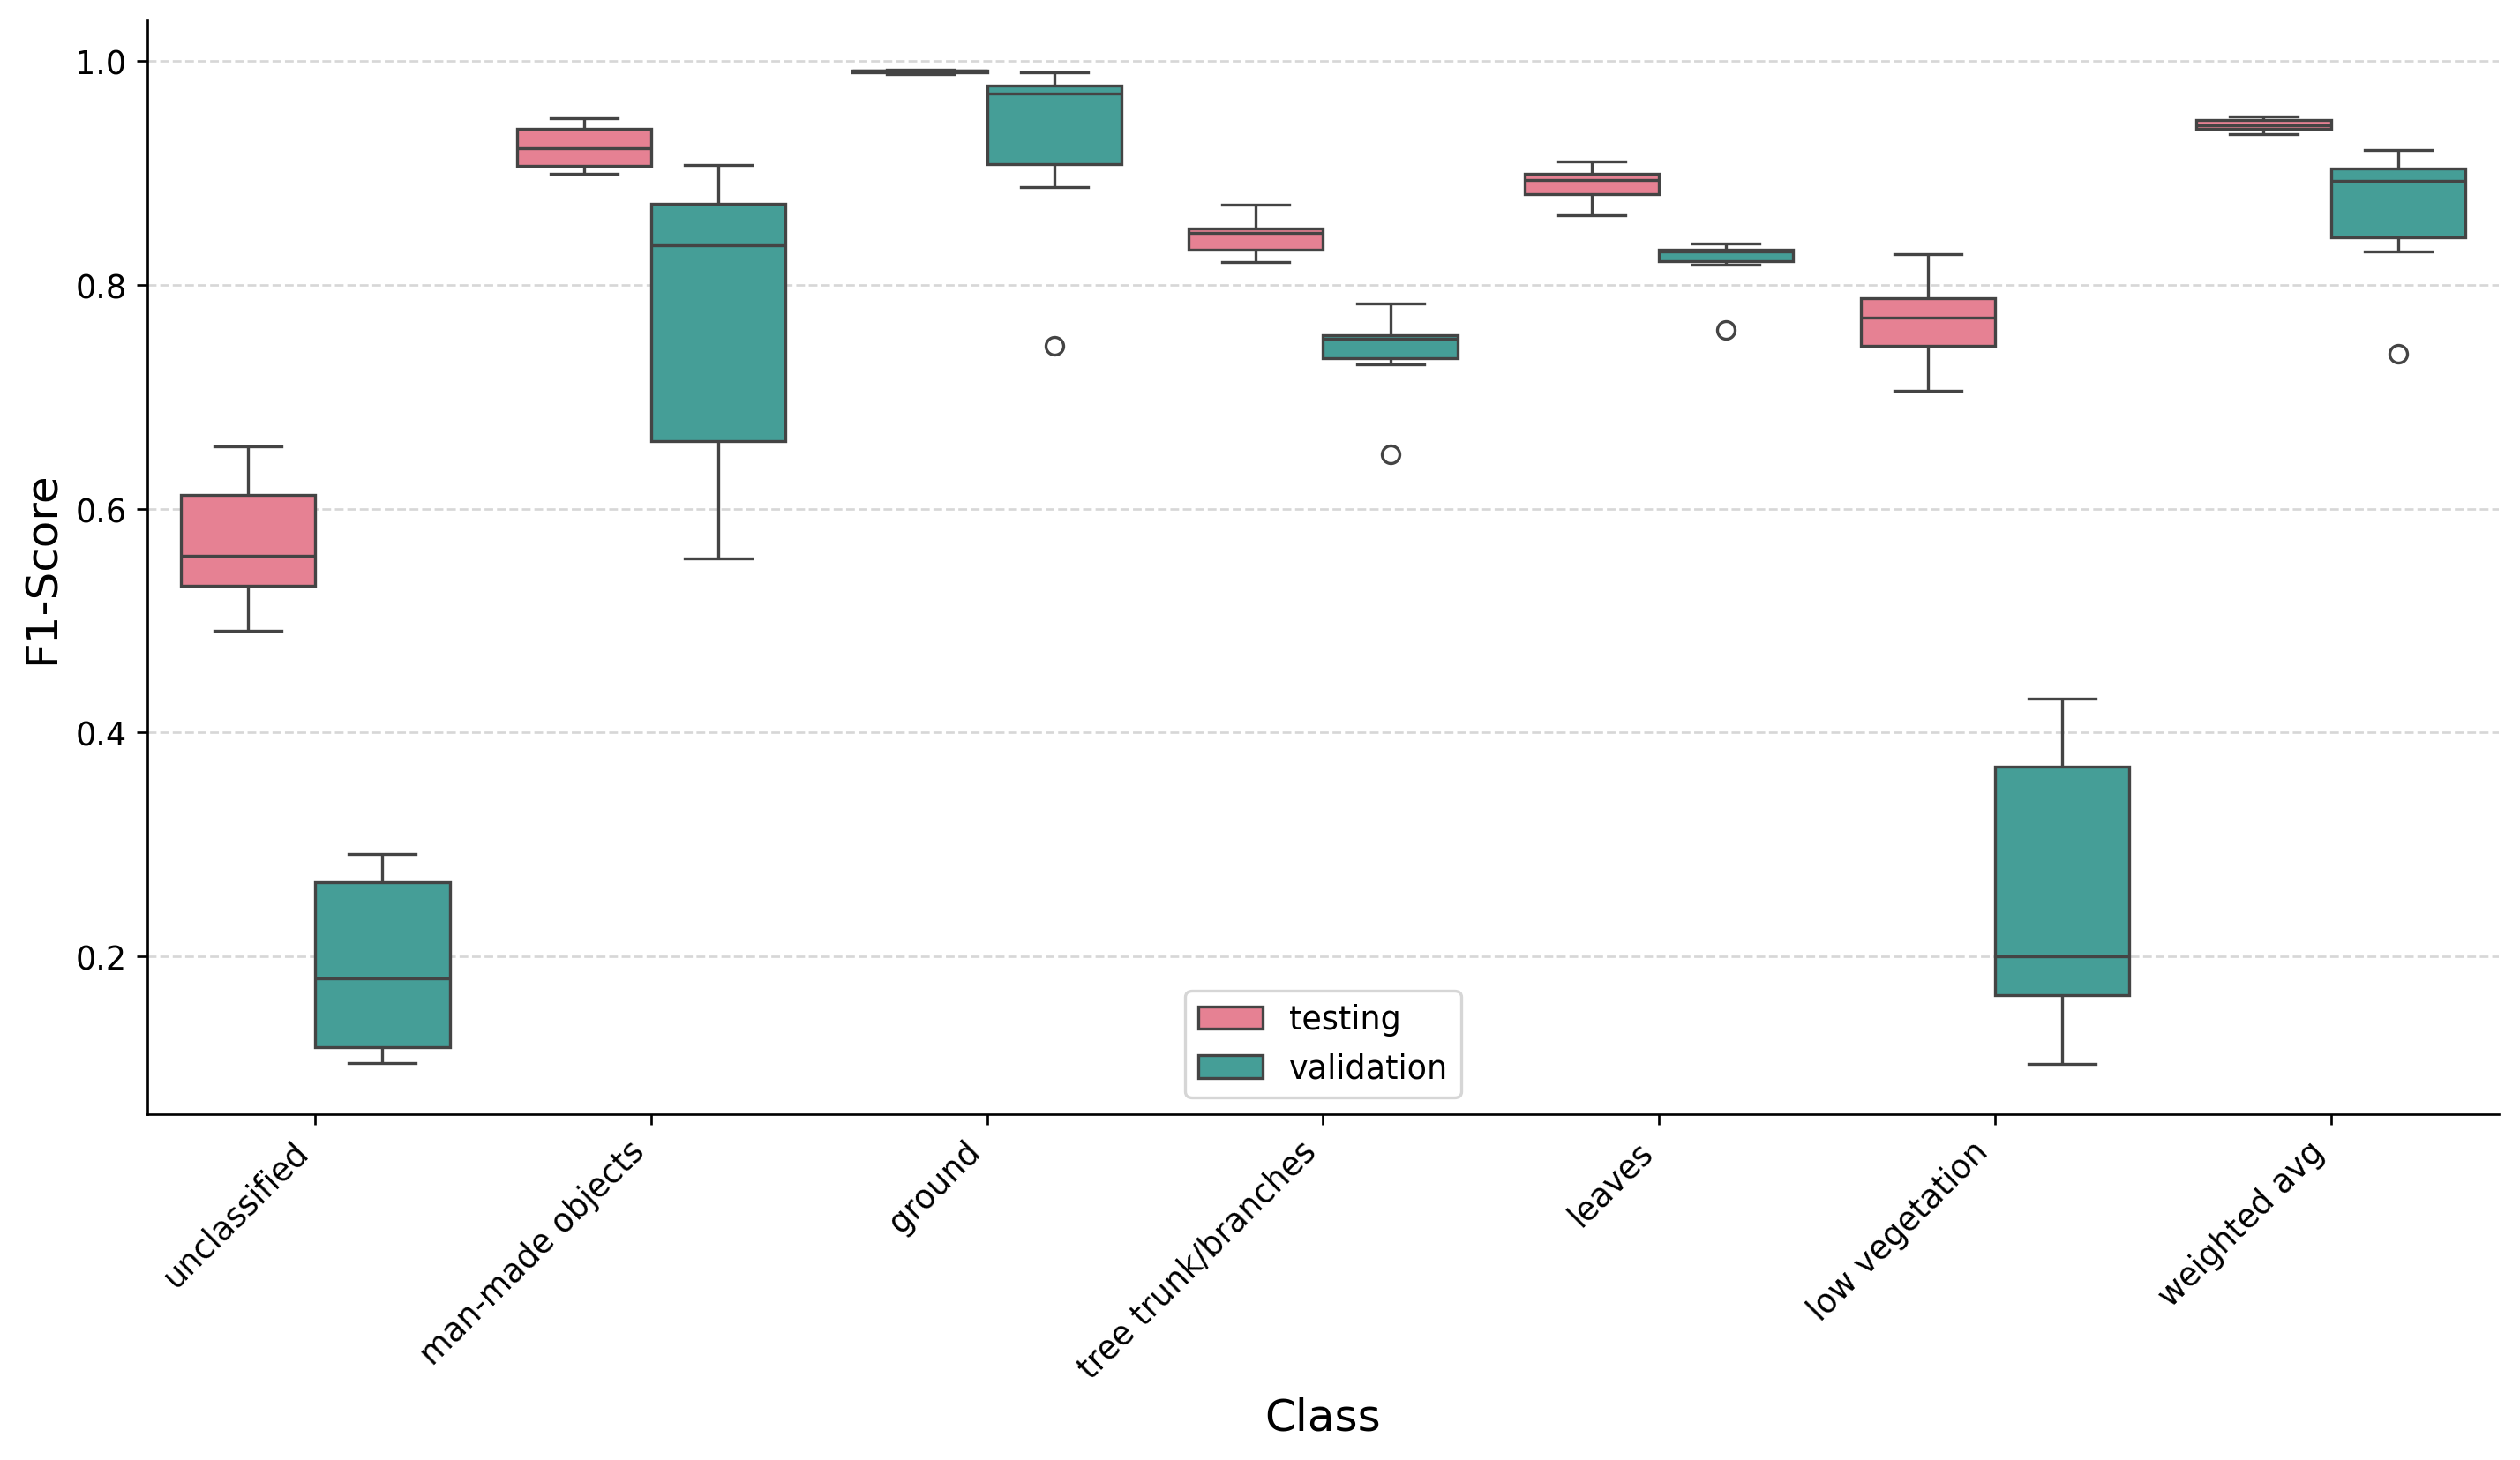

In [37]:
fig, ax1 = plt.subplots(figsize=(12, 7)) 

box_plot = sns.boxplot(x='attribute', y='f1-score', data=all_results, hue='mode', palette=sns.color_palette("husl", 2), ax=ax1)

# Highlight 'weighted avg' with light grey color
for i, artist in enumerate(box_plot.artists):
    print(i, artist.get_facecolor())
    print(artist)
    
    # This artist contains rectangle for boxplot
    if box_plot.get_xticklabels()[i].get_text() == 'weighted avg':
        print('weighted avg')
        artist.set_facecolor('lightgrey')

ax1.set_xlabel('Class', fontdict={'size': 15})
ax1.set_ylabel('F1-Score', fontdict={'size': 15})

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Set the size of the tick labels
ax1.tick_params(axis='y', labelsize=11)
ax1.tick_params(axis='x', labelsize=11)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')

# Add grid
ax1.grid(True, axis='y', linestyle='--', alpha=0.5)

# Ajust legend
ax1.legend(loc='lower center', fontsize=11, title='')

plt.tight_layout()
plt.show()

In [38]:
all_results.groupby(['attribute', 'mode'])['f1-score'].describe()

count      mean       std       min       25%  \
attribute           mode                                                        
ground              testing       6.0  0.990962  0.001636  0.988093  0.990373   
                    validation    6.0  0.924345  0.094953  0.745681  0.908408   
leaves              testing       6.0  0.889706  0.017266  0.861964  0.881347   
                    validation    6.0  0.817818  0.029138  0.759703  0.820950   
low vegetation      testing       6.0  0.767656  0.042429  0.705683  0.745264   
                    validation    6.0  0.252094  0.139645  0.103295  0.165031   
man-made objects    testing       6.0  0.923335  0.020676  0.899602  0.906645   
                    validation    6.0  0.770164  0.151334  0.555459  0.660543   
tree trunk/branches testing       6.0  0.843913  0.018397  0.820709  0.831276   
                    validation    6.0  0.736619  0.046512  0.648566  0.734172   
unclassified        testing       6.0  0.568991  0.062182  0.490602  0.531006   
                    validation    6.0  0.191432  0.084817  0.104584  0.118284   
weighted avg        testing       6.0  0.943188  0.006004  0.934734  0.939912   
                    validation    6.0  0.863218  0.068823  0.738465  0.842875   

                                     50%       75%       max  
attribute           mode                                      
ground              testing     0.991886  0.991901  0.992131  
                    validation  0.970858  0.978358  0.990222  
leaves              testing     0.893842  0.899150  0.910490  
                    validation  0.829955  0.831875  0.836833  
low vegetation      testing     0.770936  0.788358  0.827505  
                    validation  0.199521  0.369629  0.430364  
man-made objects    testing     0.922329  0.939777  0.948739  
                    validation  0.835157  0.872733  0.907615  
tree trunk/branches testing     0.846317  0.850668  0.871757  
                    validation  0.751539  0.755184  0.783286  
unclassified        testing     0.557782  0.612158  0.655418  
                    validation  0.180233  0.265970  0.291359  
weighted avg        testing     0.942627  0.947711  0.950730  
                    validation  0.893042  0.904301  0.920550

## Confusion matrices

### Training

In [98]:
cnf_mat_testing_results_path = root_dir / 'data/final_results/1_best_overall_performance/confusion_matrices_testing'

In [99]:
# Initialize a matrix to hold the sum
sum_matrix = None

# Create a Path object
path = Path(cnf_mat_testing_results_path)

# Loop through all .csv files in the directory
for filename in path.glob('*.csv'):
    # Load the matrix from the file
    matrix = np.loadtxt(filename, delimiter=',')

    # If this is the first matrix, initialize sum_matrix
    if sum_matrix is None:
        sum_matrix = matrix
    else:
        # Add the matrix to the sum
        sum_matrix += matrix

# Normalize the sum_matrix over the rows
row_sums = sum_matrix.sum(axis=1, keepdims=True)
normalized_matrix = sum_matrix / row_sums

names = ['unclassified', 'man-made objects', 'ground', 'tree trunk/branches', 'leaves', 'low vegetation']
cnf_mat_testing_df = pd.DataFrame(np.round(normalized_matrix,4), index=names, columns=names)

In [100]:
cnf_mat_testing_df

,unclassified,man-made objects,ground,tree trunk/branches,leaves,low vegetation
unclassified,0.7152,0.1999,0.0300,0.0123,0.0107,0.0318
man-made objects,0.0324,0.9035,0.0352,0.0070,0.0056,0.0163
ground,0.0001,0.0009,0.9971,0.0001,0.0002,0.0016
tree trunk/branches,0.0142,0.0203,0.0139,0.8564,0.0883,0.0069
leaves,0.0195,0.0026,0.0127,0.1066,0.8546,0.0041
low vegetation,0.0142,0.0211,0.0710,0.0058,0.0003,0.8876


### Validation

In [102]:
cnf_mat_validation_results_path = root_dir / 'data/final_results/1_best_overall_performance/confusion_matrices_validation'

In [103]:
# Initialize a matrix to hold the sum
sum_matrix = None

# Create a Path object
path = Path(cnf_mat_validation_results_path)

# Loop through all .csv files in the directory
for filename in path.glob('*.csv'):
    # Load the matrix from the file
    matrix = np.loadtxt(filename, delimiter=',')

    # If this is the first matrix, initialize sum_matrix
    if sum_matrix is None:
        sum_matrix = matrix
    else:
        # Add the matrix to the sum
        sum_matrix += matrix

# Normalize the sum_matrix over the rows
row_sums = sum_matrix.sum(axis=1, keepdims=True)
normalized_matrix = sum_matrix / row_sums

names = ['unclassified', 'man-made objects', 'ground', 'tree trunk/branches', 'leaves', 'low vegetation']
cnf_mat_validation_df = pd.DataFrame(np.round(normalized_matrix,4), index=names, columns=names)

In [104]:
cnf_mat_validation_df

,unclassified,man-made objects,ground,tree trunk/branches,leaves,low vegetation
unclassified,0.6751,0.1385,0.0607,0.0481,0.0168,0.0608
man-made objects,0.0492,0.8525,0.0099,0.0837,0.0015,0.0032
ground,0.0200,0.0329,0.8997,0.0004,0.0003,0.0466
tree trunk/branches,0.0337,0.1250,0.0194,0.7444,0.0644,0.0132
leaves,0.0514,0.0038,0.0083,0.1804,0.7387,0.0174
low vegetation,0.2094,0.0285,0.1275,0.0012,0.0012,0.6322


# Benchmarking 

**Scanline approach versus 3D approach**

Attributes used:
- Z, red, green, vert_angle, slope (zenith_angle), curvature, roughness, nx, ny, nz

Statistics used: 
- Skewness, 2nd percentile, 75th percentile, 25th percentile, StdDev, 98th percentile

--> Total of 60 features for both approaches

XGBoost parameters used: 
- n_estimators: 100
- max_depth: 3
- learning_rate: 0.3

## Resources scanline approach

In [3]:
performance_metrics_path = root_dir / "data/final_results/4_performance_test/scanline_approach/performance_report/performance_metrics.csv"
performance_metrics = pd.read_csv(performance_metrics_path)

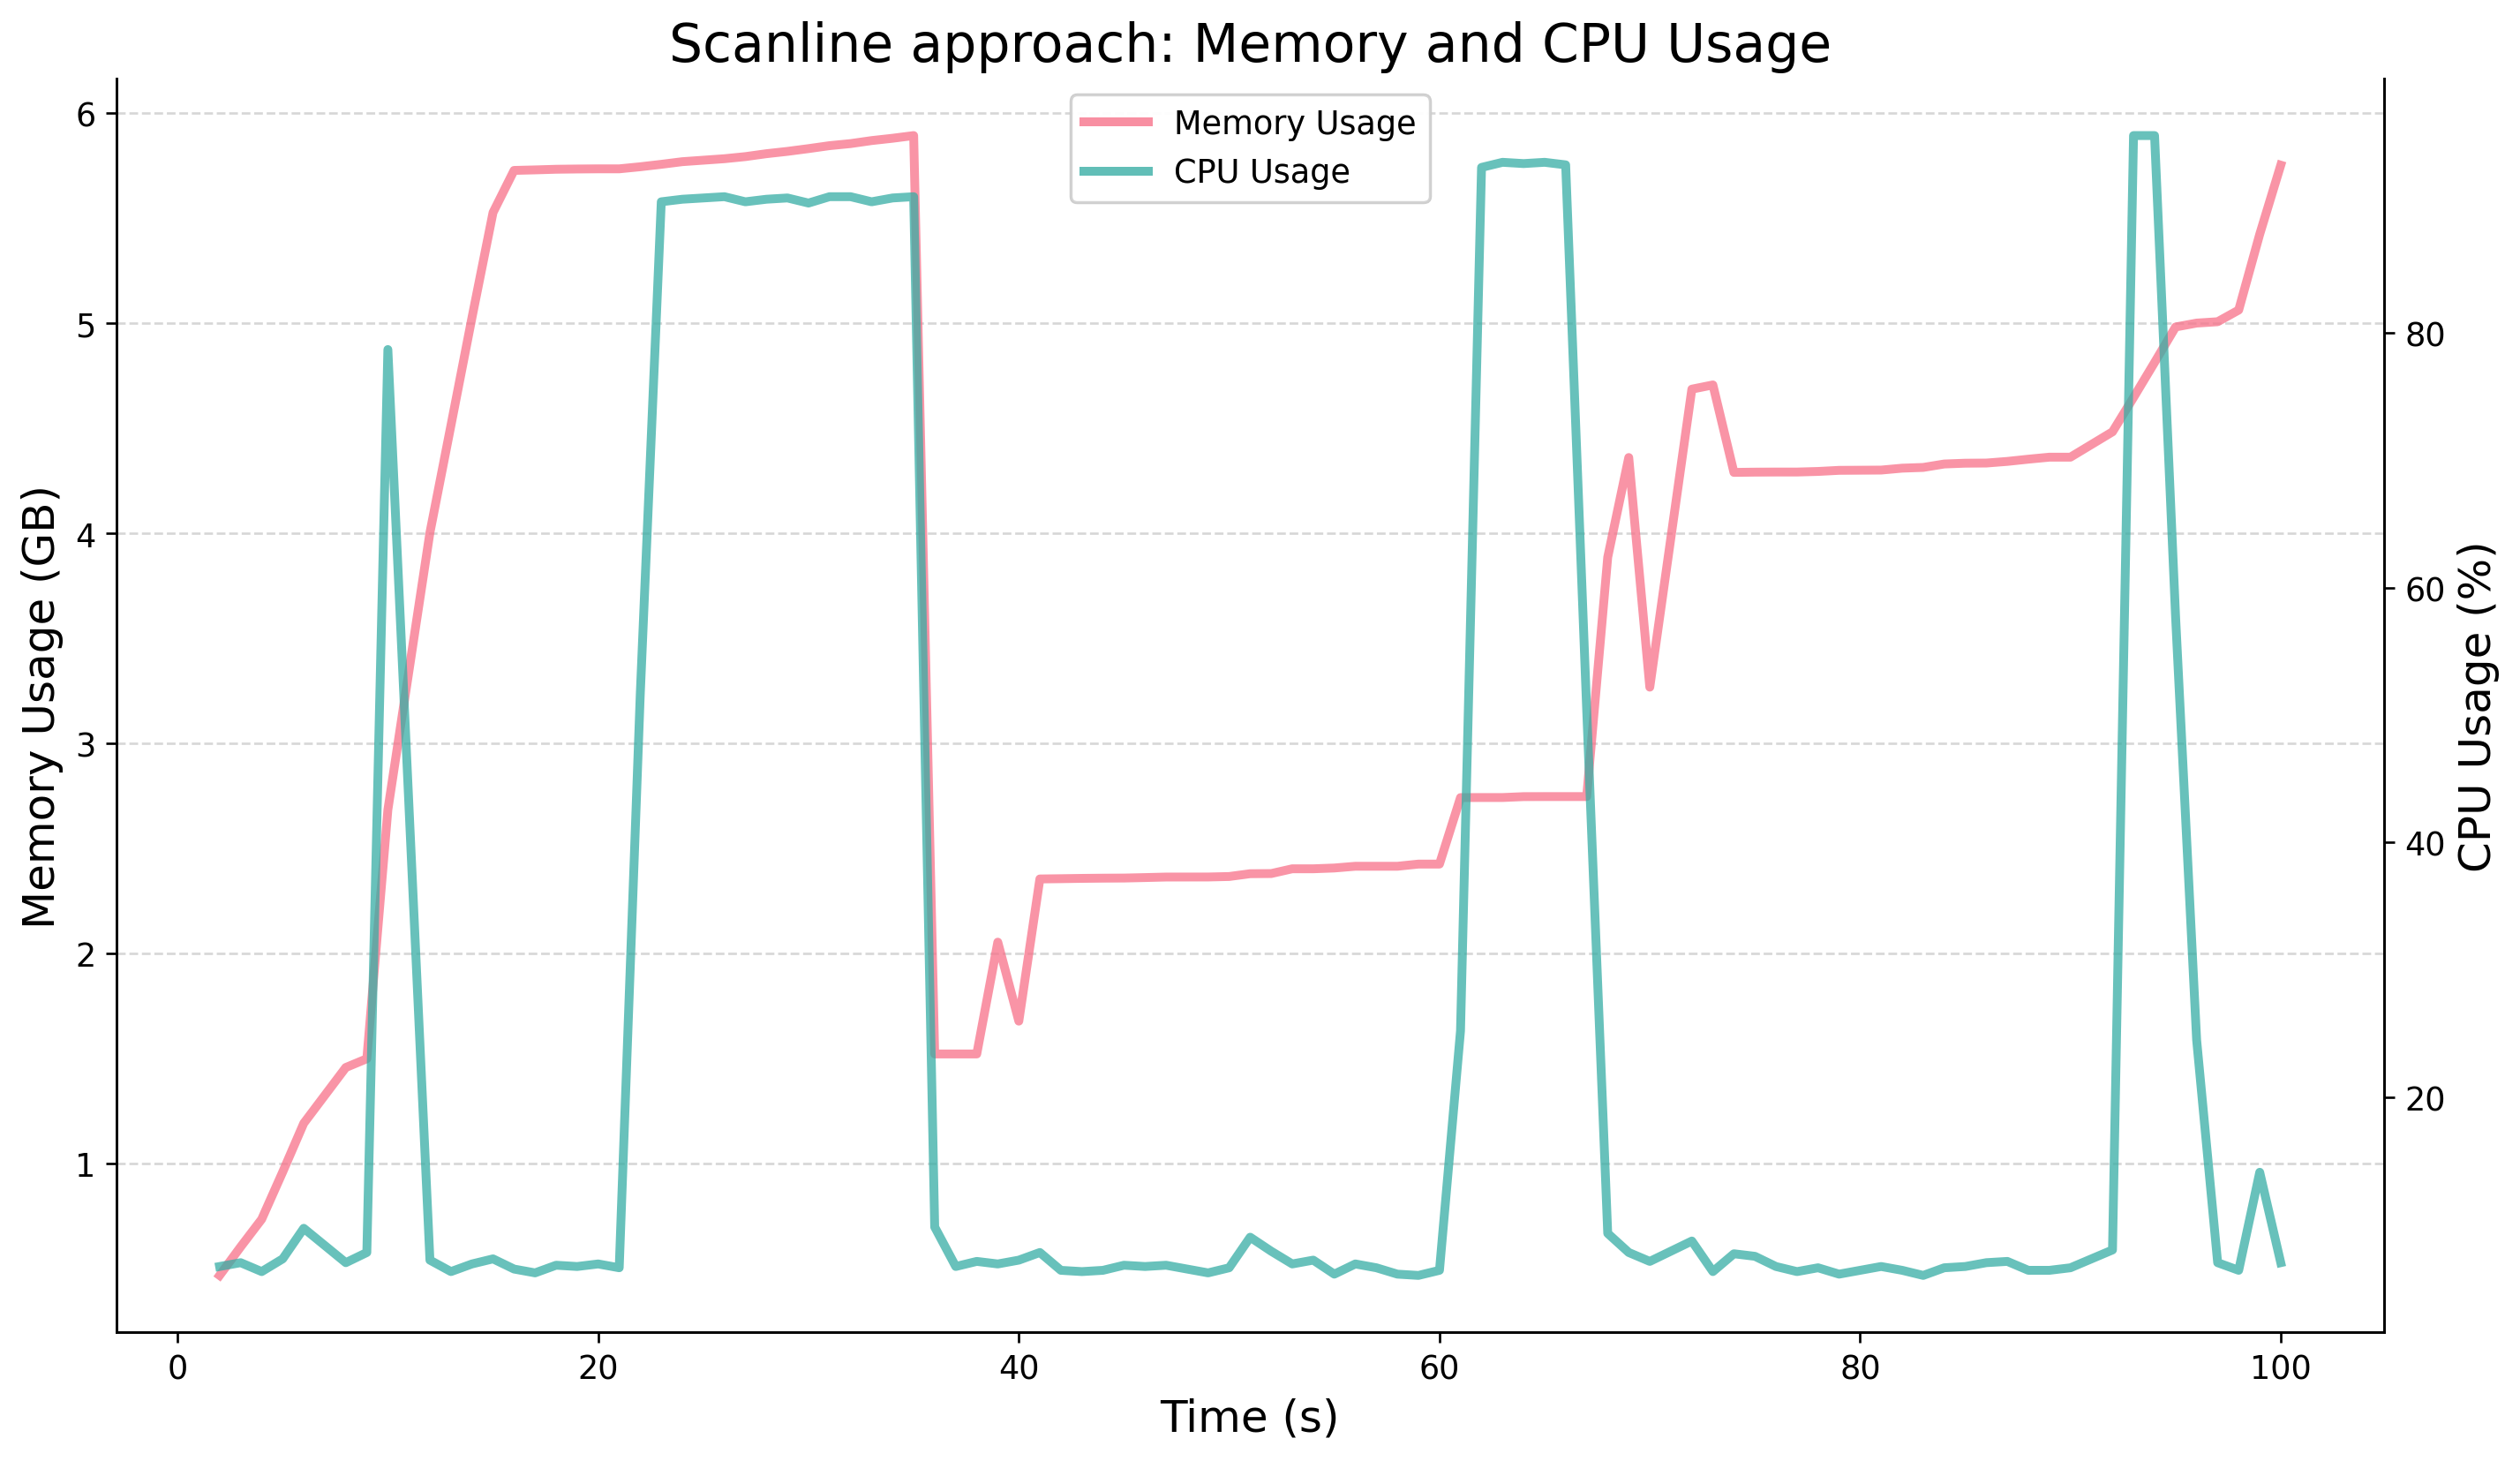

In [21]:
fig, ax1 = plt.subplots(figsize=(12, 7)) 

line1 = sns.lineplot(x='Seconds_Since_Start', 
                     y='Memory Usage (GB)', 
                     data=performance_metrics, 
                     color=sns.color_palette("husl", 2)[0], 
                     ax=ax1, 
                     label='Memory Usage', 
                     linewidth=3, 
                     alpha=0.75)

ax1.set_xlabel('Time (s)', fontdict={'size': 15})
ax1.set_ylabel('Memory Usage (GB)', fontdict={'size': 15})

ax1.spines['top'].set_visible(False)

# Create a second y-axis
ax2 = ax1.twinx()
line2 = sns.lineplot(x='Seconds_Since_Start', 
                     y='CPU Usage (%)', 
                     data=performance_metrics, 
                     color=sns.color_palette("husl", 2)[1], 
                     ax=ax2, 
                     label='CPU Usage',
                     linewidth=3, 
                     alpha=0.75)
ax2.set_ylabel('CPU Usage (%)', fontdict={'size': 15})
ax2.spines['top'].set_visible(False)

# Set the size of the tick labels
ax1.tick_params(axis='y', labelsize=11)
ax1.tick_params(axis='x', labelsize=11)
ax2.tick_params(axis='y', labelsize=11)

# Add grid
ax1.grid(True, axis='y', linestyle='--', alpha=0.5)

# Collect labels and handles
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

# Create a single legend for both lines
ax1.legend(lines + lines2, labels + labels2, loc='upper center', fontsize=11)
ax2.legend(lines + lines2, labels + labels2, loc='upper center', fontsize=11)

# Set the title
ax1.set_title('Scanline approach: Memory and CPU Usage', fontdict={'size': 18})

plt.tight_layout()
plt.show()

## Resources 3D classification approach

In [24]:
performance_metrics_path = root_dir / "data/final_results/4_performance_test/cls_3d/performance_report/performance_metrics.csv"
execution_time_path = root_dir / "data/final_results/4_performance_test/cls_3d/performance_report/execution_time.csv"
performance_metrics_3d = pd.read_csv(performance_metrics_path)
execution_time = pd.read_csv(execution_time_path)

performance_metrics_3d['Voxel Size (cm)'] *= 100

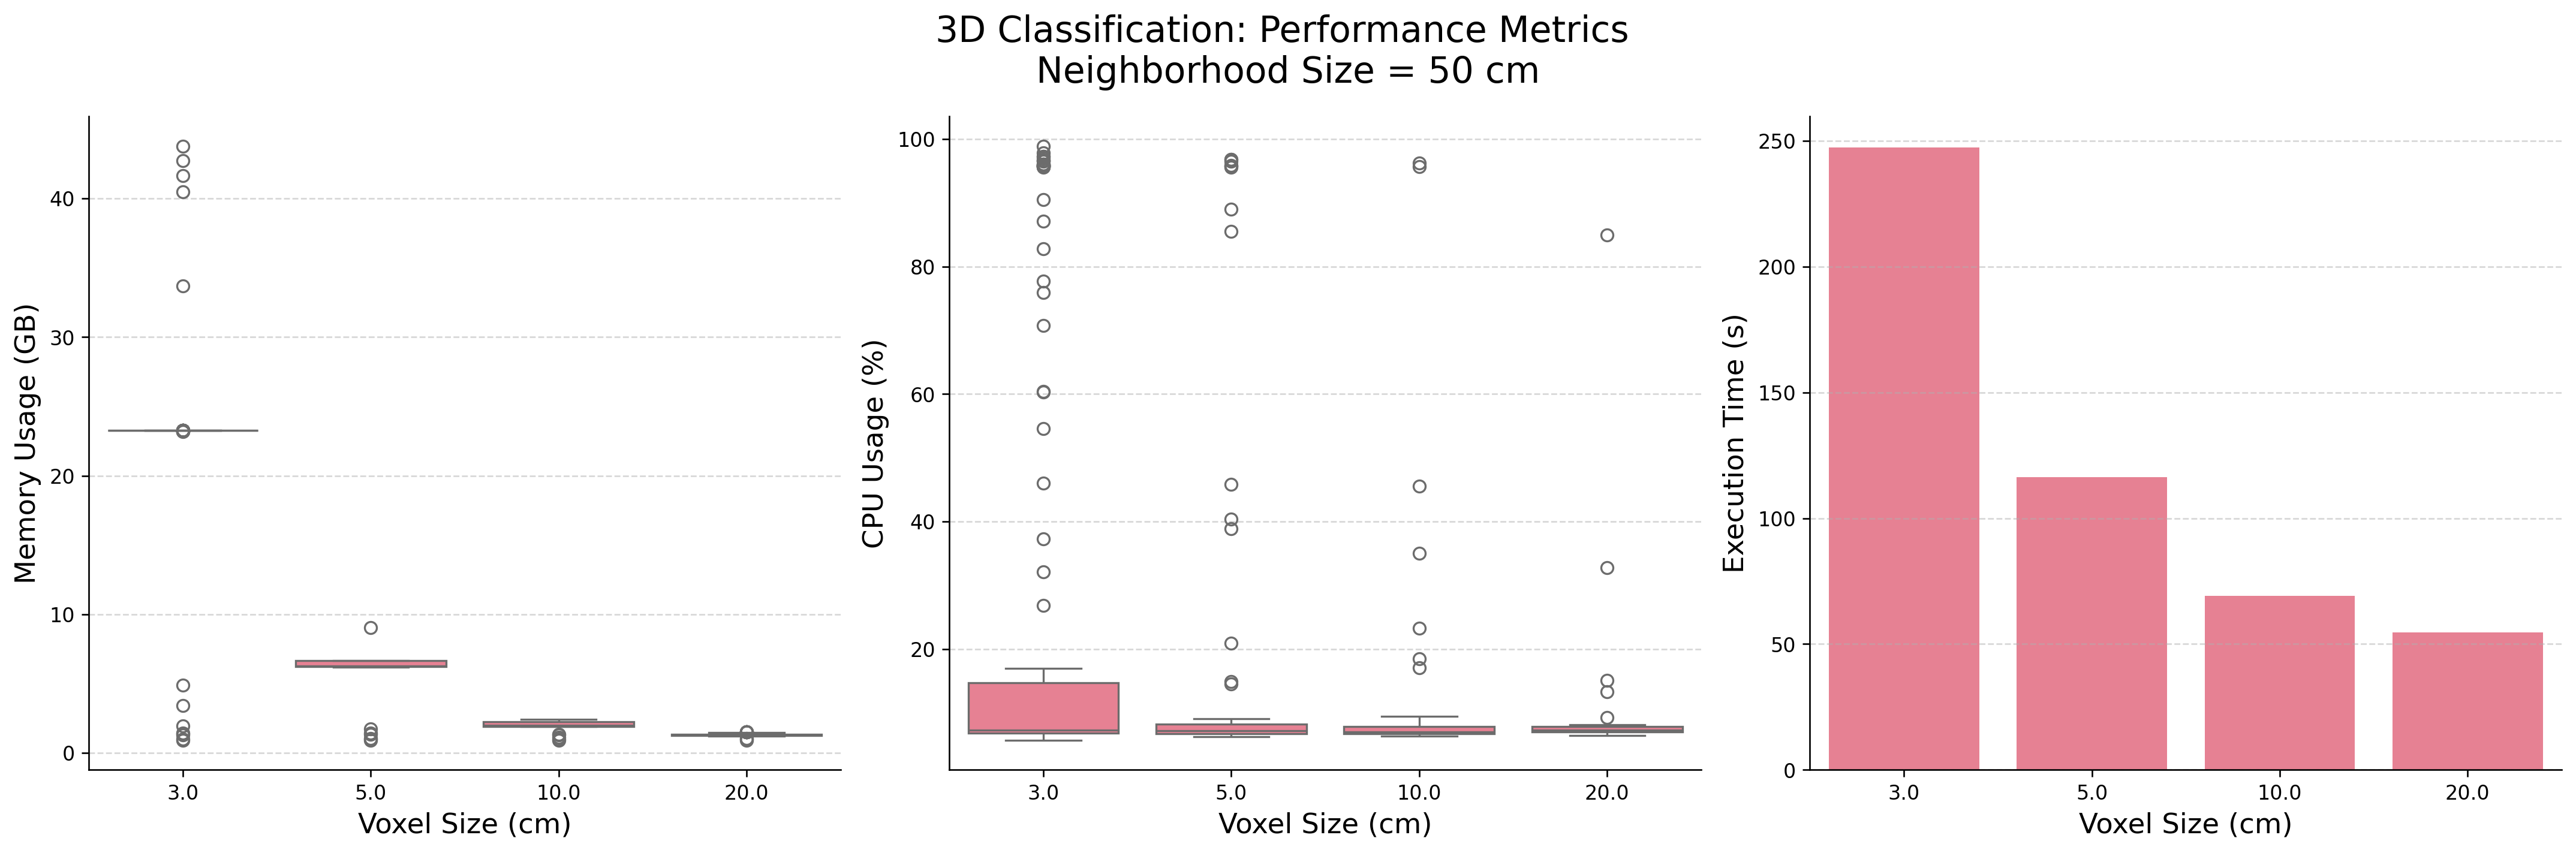

In [69]:
# Create a figure and a 1x3 subplot
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharex=True)

# Left plot: Memory Usage vs Voxel Size
sns.boxplot(x='Voxel Size (cm)', y='Memory Usage (GB)', data=performance_metrics_3d, ax=axs[0], color=sns.color_palette("husl", 2)[0])
axs[0].set_ylabel('Memory Usage (GB)', size=14)
axs[0].set_xlabel('Voxel Size (cm)', size=14)
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)
axs[0].grid(True, axis='y', linestyle='--', alpha=0.5)

# Middle plot: CPU Usage vs Voxel Size
sns.boxplot(x='Voxel Size (cm)', y='CPU Usage (%)', data=performance_metrics_3d, ax=axs[1], color=sns.color_palette("husl", 2)[0])
axs[1].set_ylabel('CPU Usage (%)', size=14)
axs[1].set_xlabel('Voxel Size (cm)', size=14)
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].grid(True, axis='y', linestyle='--', alpha=0.5)

# Right plot: Execution Time vs Voxel Size
sns.barplot(x='voxel_size (cm)', y='execution_time', data=execution_time, ax=axs[2], color=sns.color_palette("husl", 2)[0])
axs[2].set_ylabel('Execution Time (s)', size=14)
axs[2].set_xlabel('Voxel Size (cm)', size=14)
axs[2].spines['top'].set_visible(False)
axs[2].spines['right'].set_visible(False)
axs[2].grid(True, axis='y', linestyle='--', alpha=0.5)

# Set the title
fig.suptitle('3D Classification: Performance Metrics \nNeighborhood Size = 50 cm', size=18)

# Adjust the subplot parameters for a better layout
plt.tight_layout()

plt.show()

# Classification comparison

## Testing data

In [72]:
testing_results_path = root_dir / 'data/final_results/5_comparison_3d_scanline_approach/cls_3d/radius0.5_voxel0.05/classification_result_3d_2d_comparison/classification_report_testing/cls_report_testing_3d_2d.csv'
testing_results = pd.read_csv(testing_results_path)

# Rename the first column
testing_results = testing_results.rename(columns={'Unnamed: 0': 'attribute'})

In [74]:
testing_results_path = root_dir / 'data/final_results/5_comparison_3d_scanline_approach/cls_3d/radius0.5_voxel0.05/classification_result_3d_2d_comparison/classification_report_testing/cls_report_testing_3d_2d.csv'
validation_results_path = root_dir / 'data/final_results/5_comparison_3d_scanline_approach/cls_3d/radius0.5_voxel0.05/classification_result_3d_2d_comparison/classification_report_validation/cls_report_validation_3d_2d.csv'

testing_results = pd.read_csv(testing_results_path)
validation_results = pd.read_csv(validation_results_path)

# Rename the first columns
testing_results = testing_results.rename(columns={'Unnamed: 0': 'attribute'})
testing_results['mode'] = 'testing'
validation_results = validation_results.rename(columns={'Unnamed: 0': 'attribute'})
validation_results['mode'] = 'validation'

# Remove 'accuracy' and 'macro avg' rows
testing_results = testing_results[testing_results['attribute'] != 'accuracy']
testing_results = testing_results[testing_results['attribute'] != 'macro avg']
validation_results = validation_results[validation_results['attribute'] != 'accuracy']
validation_results = validation_results[validation_results['attribute'] != 'macro avg']

# Merge the two dataframes
all_results = pd.concat([testing_results, validation_results])

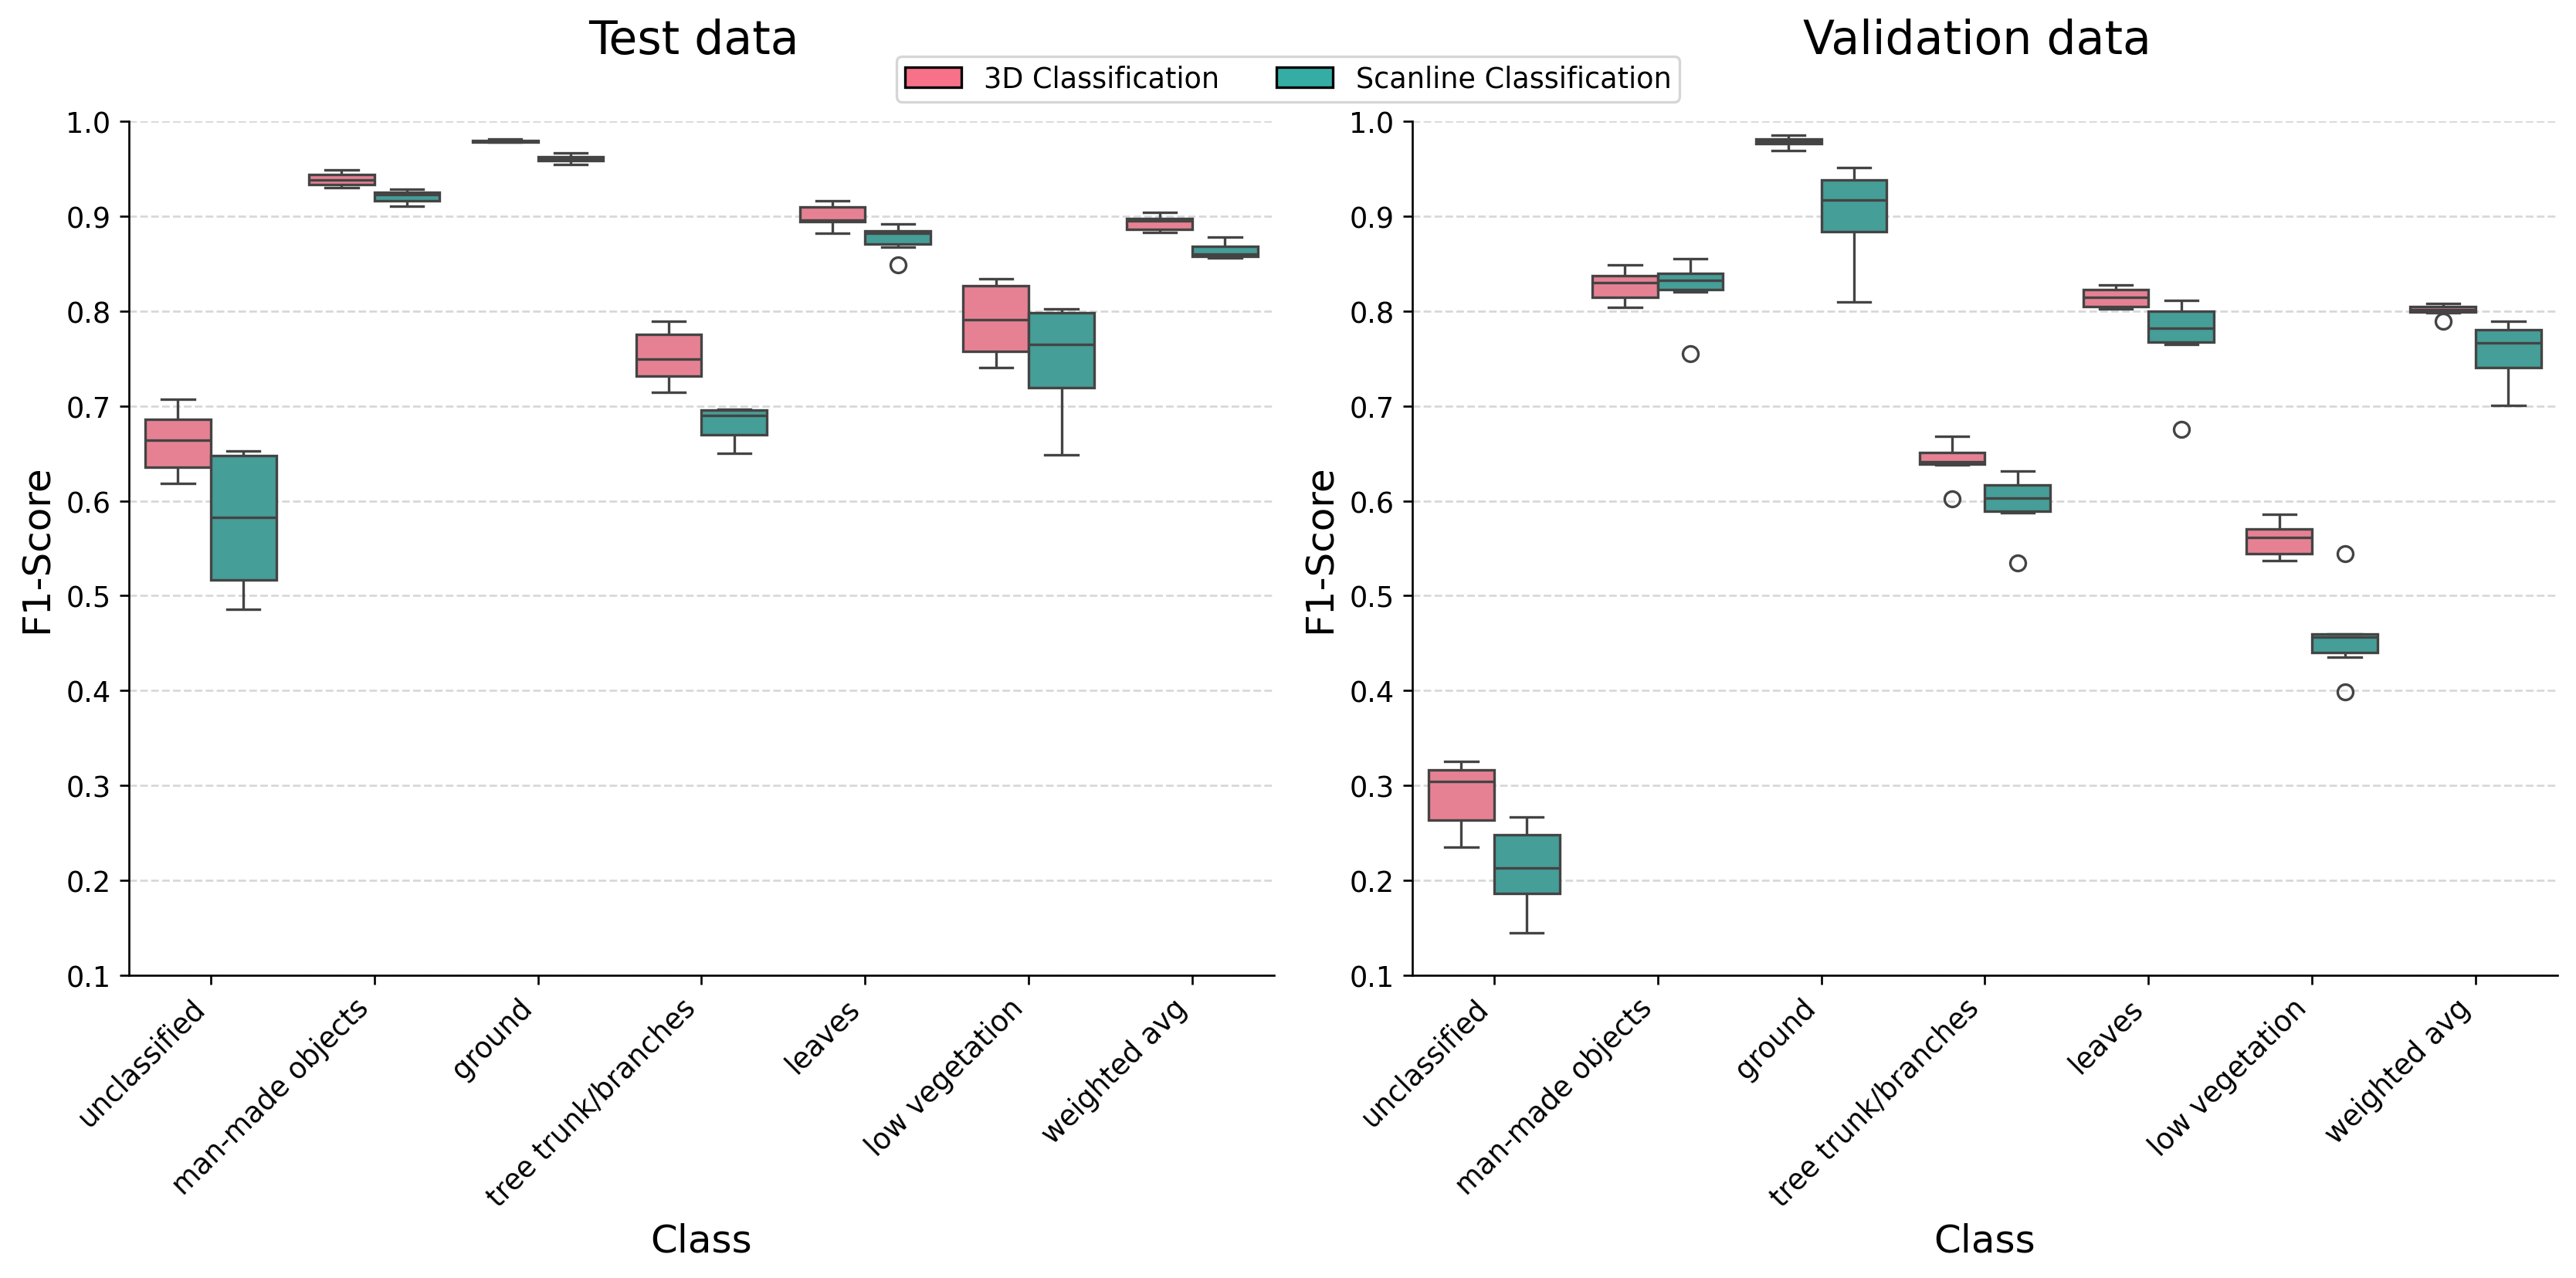

In [131]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7)) 

# First subplot for testing data
box_plot1 = sns.boxplot(x='attribute', y='f1-score', data=testing_results, hue='id', palette=sns.color_palette("husl", 2), ax=ax1)

# Highlight 'weighted avg' with light grey color in testing data
for i, artist in enumerate(box_plot1.artists):
    if box_plot1.get_xticklabels()[i].get_text() == 'weighted avg':
        artist.set_facecolor('lightgrey')

ax1.set_xlabel('Class', fontdict={'size': 15})
ax1.set_ylabel('F1-Score', fontdict={'size': 15})
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.tick_params(axis='y', labelsize=11)
ax1.tick_params(axis='x', labelsize=11)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
ax1.grid(True, axis='y', linestyle='--', alpha=0.5)
ax1.set_title('Test data \n', fontdict={'size': 18})
ax1.set_ylim(0.1, 1)

# Second subplot for validation data
box_plot2 = sns.boxplot(x='attribute', y='f1-score', data=validation_results, hue='id', palette=sns.color_palette("husl", 2), ax=ax2)

# Highlight 'weighted avg' with light grey color in validation data
for i, artist in enumerate(box_plot2.artists):
    if box_plot2.get_xticklabels()[i].get_text() == 'weighted avg':
        artist.set_facecolor('lightgrey')

ax2.set_xlabel('Class', fontdict={'size': 15})
ax2.set_ylabel('F1-Score', fontdict={'size': 15})
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.tick_params(axis='y', labelsize=11)
ax2.tick_params(axis='x', labelsize=11)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
ax2.grid(True, axis='y', linestyle='--', alpha=0.5)
ax2.set_title('Validation data \n', fontdict={'size': 18})
ax2.set_ylim(0.1, 1)

# Create a list of legend elements
legend_elements = [Patch(facecolor=sns.color_palette("husl", 2)[0], edgecolor='black', label='3D Classification'),
                   Patch(facecolor=sns.color_palette("husl", 2)[1], edgecolor='black', label='Scanline Classification')]

# Add the legend to the figure
ax1.get_legend().remove()
ax2.get_legend().remove()
fig.legend(handles=legend_elements, loc='upper center', 
           bbox_to_anchor=(0.5, 0.96), fontsize=11, 
           title='', borderpad=0.3, frameon=True, ncol=2)

plt.tight_layout()
plt.show()

In [122]:
all_results.groupby(['attribute', 'id', 'mode'])['f1-score'].describe()

count      mean       std       min  \
attribute           id mode                                              
ground              2d testing       6.0  0.960856  0.004460  0.954246   
                       validation    6.0  0.901983  0.052869  0.809257   
                    3d testing       6.0  0.979256  0.001347  0.977890   
                       validation    6.0  0.978279  0.005672  0.969021   
leaves              2d testing       6.0  0.876112  0.015506  0.848918   
                       validation    6.0  0.769927  0.049410  0.675537   
                    3d testing       6.0  0.899710  0.012952  0.882003   
                       validation    6.0  0.814371  0.011136  0.802627   
low vegetation      2d testing       6.0  0.749077  0.060883  0.648635   
                       validation    6.0  0.458439  0.048030  0.398731   
                    3d testing       6.0  0.790181  0.040569  0.740682   
                       validation    6.0  0.559539  0.018980  0.536847   
man-made objects    2d testing       6.0  0.920810  0.006786  0.910661   
                       validation    6.0  0.822845  0.035240  0.754992   
                    3d testing       6.0  0.938932  0.007282  0.930293   
                       validation    6.0  0.826967  0.017192  0.803906   
tree trunk/branches 2d testing       6.0  0.681248  0.019585  0.650137   
                       validation    6.0  0.596234  0.034070  0.534733   
                    3d testing       6.0  0.751907  0.029655  0.714132   
                       validation    6.0  0.640662  0.021997  0.602319   
unclassified        2d testing       6.0  0.577684  0.077141  0.485582   
                       validation    6.0  0.212160  0.046407  0.144371   
                    3d testing       6.0  0.661983  0.034560  0.618477   
                       validation    6.0  0.289658  0.037254  0.234814   
weighted avg        2d testing       6.0  0.863550  0.008625  0.855814   
                       validation    6.0  0.756626  0.033863  0.700445   
                    3d testing       6.0  0.893238  0.008240  0.883123   
                       validation    6.0  0.800758  0.006577  0.789304   

                                        25%       50%       75%       max  
attribute           id mode                                                
ground              2d testing     0.958683  0.961010  0.963093  0.967178  
                       validation  0.883384  0.916949  0.937976  0.951560  
                    3d testing     0.978409  0.978791  0.979957  0.981441  
                       validation  0.976244  0.978795  0.981206  0.985660  
leaves              2d testing     0.870898  0.881733  0.884231  0.891940  
                       validation  0.767357  0.781805  0.800282  0.811432  
                    3d testing     0.894616  0.895965  0.909652  0.915944  
                       validation  0.804458  0.814492  0.822944  0.827740  
low vegetation      2d testing     0.719589  0.765162  0.797957  0.802216  
                       validation  0.440233  0.455946  0.459290  0.544608  
                    3d testing     0.757470  0.790646  0.826585  0.834135  
                       validation  0.544146  0.561734  0.570142  0.585691  
man-made objects    2d testing     0.916469  0.922650  0.925140  0.928520  
                       validation  0.822718  0.832716  0.839520  0.855473  
                    3d testing     0.933725  0.938104  0.944134  0.948679  
                       validation  0.814222  0.830001  0.837620  0.848771  
tree trunk/branches 2d testing     0.669551  0.690226  0.695924  0.696414  
                       validation  0.589242  0.602559  0.616724  0.631302  
                    3d testing     0.731220  0.749652  0.775093  0.789355  
                       validation  0.638319  0.640762  0.651090  0.668093  
unclassified        2d testing     0.516509  0.582134  0.647493  0.652338  
                       validation  0.185770  0.212638  0.247972  0